Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split , RandomizedSearchCV , cross_validate
from sklearn.preprocessing import LabelEncoder , StandardScaler , FunctionTransformer , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , auc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
import shap
import joblib

📂 Data Loading & Preprocessing

In [2]:
data = pd.read_csv('../data/fraud_data/fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'] , axis=1 , inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


📂 🔧  Data Splitting, Encoding & Scaling

In [5]:
X = data.drop('isFraud' , axis=1)
Y = data['isFraud']

In [6]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 42)
numerical_columns = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']
categorical_columns = [col for col in X.columns if X[col].dtype == 'O']

x_train = pd.get_dummies(x_train , columns=categorical_columns).astype(int)
x_test = pd.get_dummies(x_test , columns=categorical_columns).astype(int)

scaler = StandardScaler()
x_train[numerical_columns] = scaler.fit_transform(x_train[numerical_columns])
x_test[numerical_columns] = scaler.transform(x_test[numerical_columns])


## 🧪  Baseline Model Evaluation (No Class Weighting)

In [7]:
# Rfc
#📝Train Prediction Report
model = RandomForestClassifier(n_estimators=300 , max_depth=5 , min_samples_split=5 , random_state=42)
model.fit(x_train , y_train)
y_pred = model.predict(x_test)
print(confusion_matrix(y_test , y_pred))

[[1270904       0]
 [   1042     578]]


In [8]:
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      0.37      0.54      6593

    accuracy                           1.00   5090096
   macro avg       1.00      0.69      0.77   5090096
weighted avg       1.00      1.00      1.00   5090096



## 📊  Define Evaluation Function

In [9]:
def shap_plot(model , x_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap.summary_plot(shap_values ,x_test , feature_names=x_test.columns )

In [10]:
def plot_results(model , x_train , x_test , y_test , threshold=0.5):

    # predict
    y_pred_prob = model.predict_proba(x_test)[:,1]
    y_pred = (y_pred_prob >= threshold).astype(int)

    #confusion matrix
    cm = confusion_matrix(y_test , y_pred)
    sns.heatmap(data=cm , annot=True , fmt='d' , cmap='Blues' , xticklabels=['non fraud' , 'fraud'] , yticklabels=['non fraud' , 'fraud'])
    plt.title('confusion matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.legend()
    plt.show()

    #roc curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


    #feature importances
    x_train = pd.DataFrame(x_train)
    feature_importances = pd.Series(model.feature_importances_ , index=x_train.columns)
    feature_importances.sort_values(ascending=False).plot(kind='barh', color = 'skyblue', figsize=(20, 12))
    plt.xlabel('feature importance score')
    plt.ylabel('feature')
    plt.title(f'feature importance in {model}')

    #classification report
    print(classification_report(y_test , y_pred))



    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


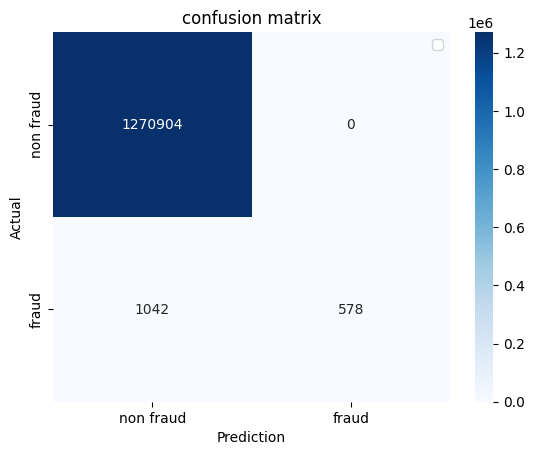

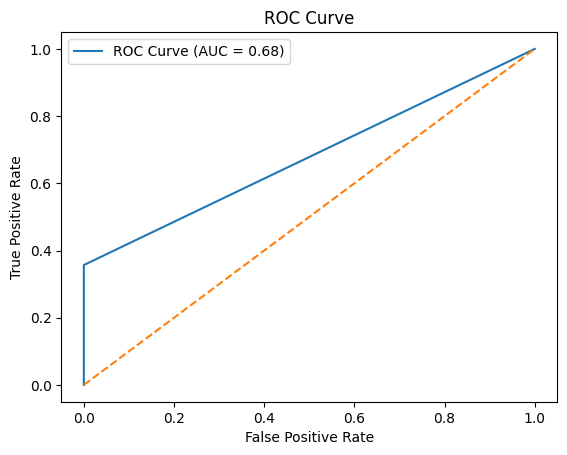

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      0.36      0.53      1620

    accuracy                           1.00   1272524
   macro avg       1.00      0.68      0.76   1272524
weighted avg       1.00      1.00      1.00   1272524



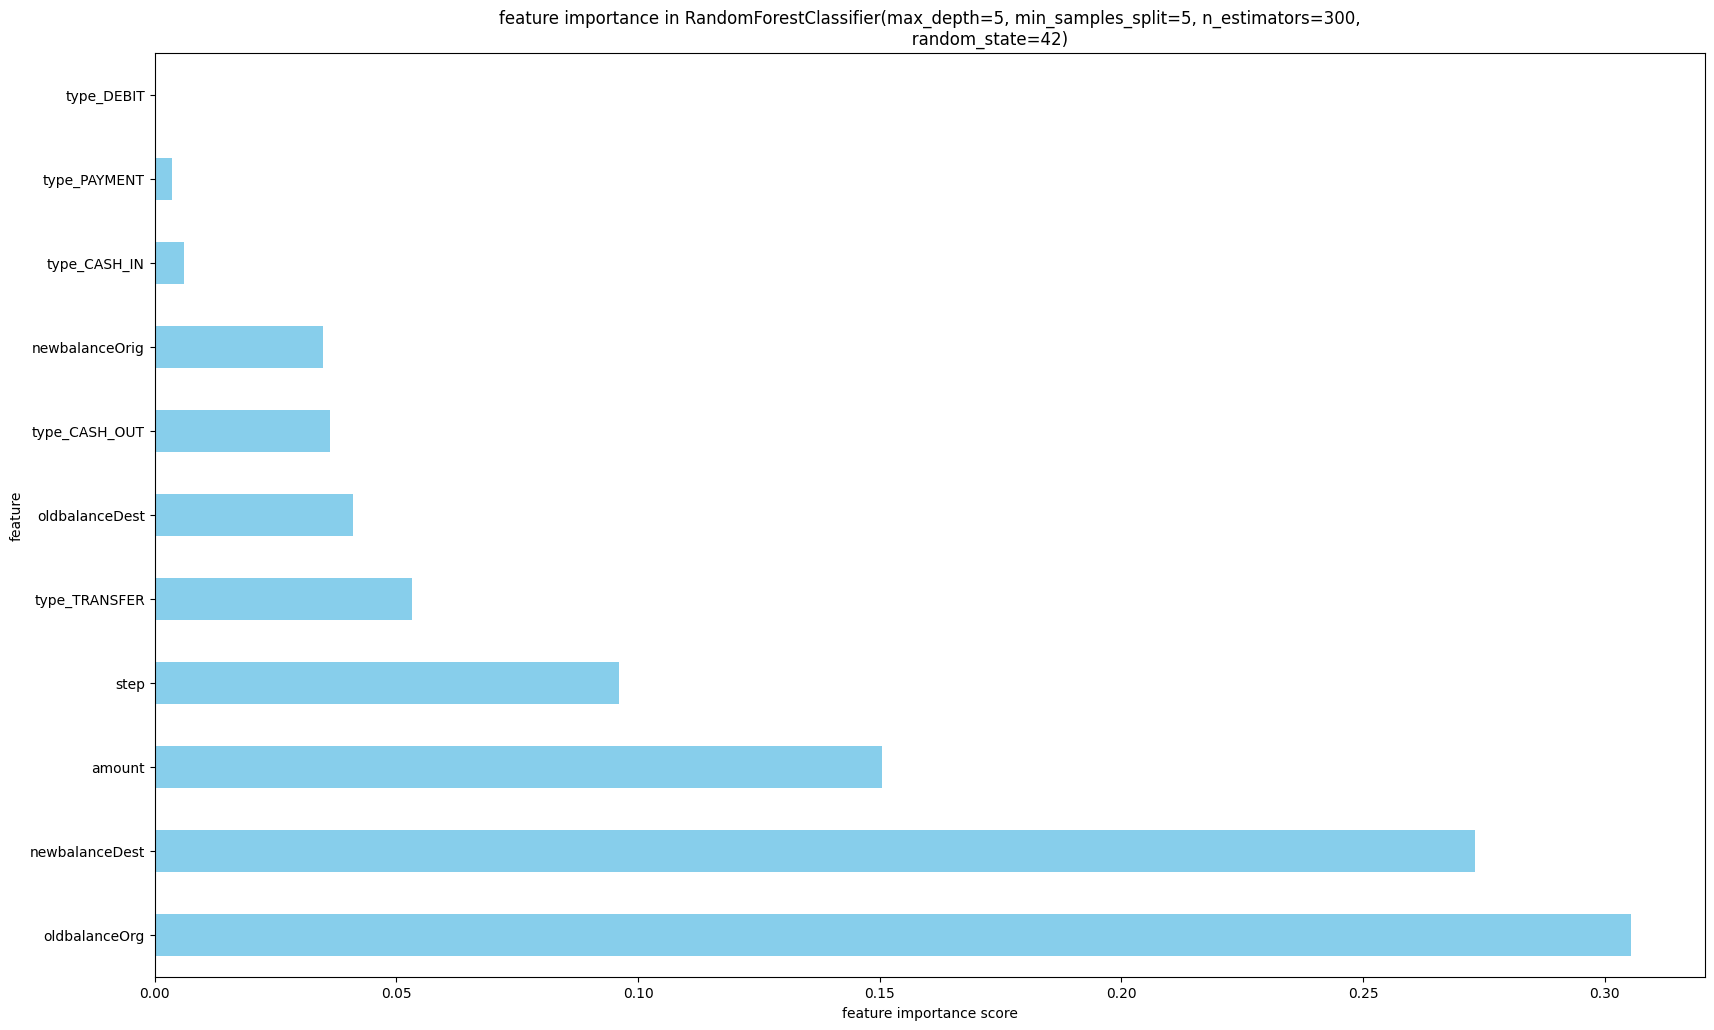

In [11]:
# result for Rfc
plot_results(model ,x_train , x_test , y_test)

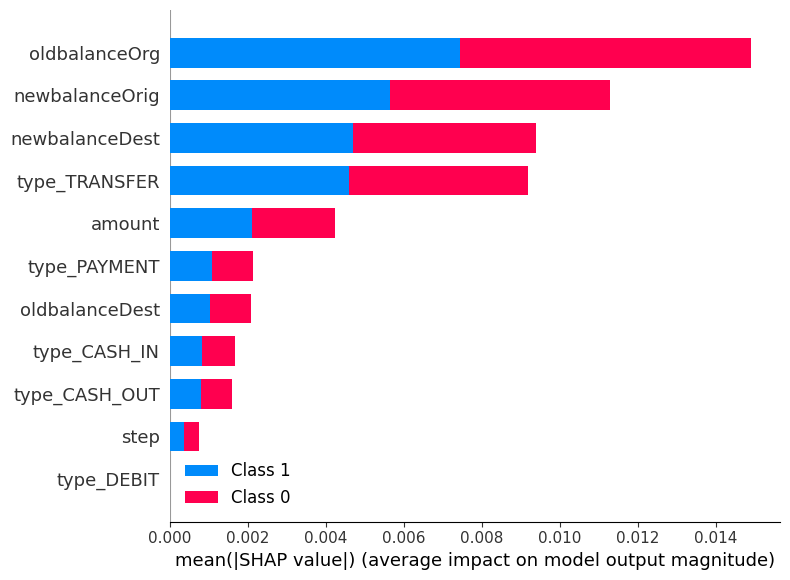

In [12]:
shap_plot(model , x_test)

🌲 XGBoost Classifier Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


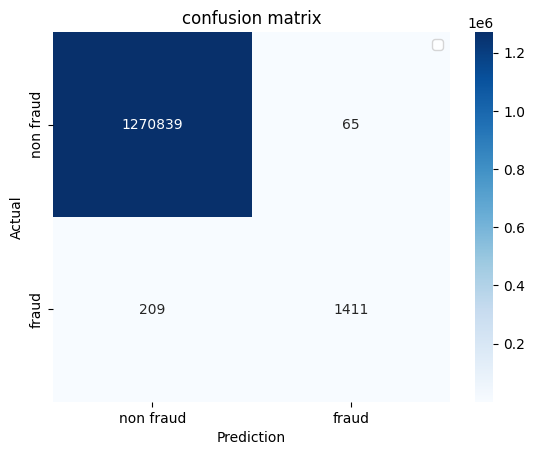

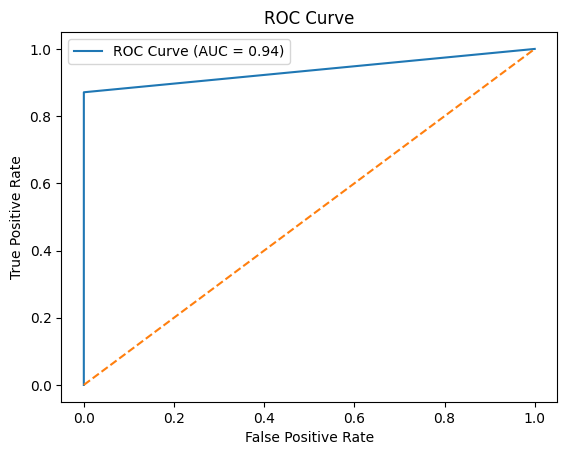

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.87      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.94      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



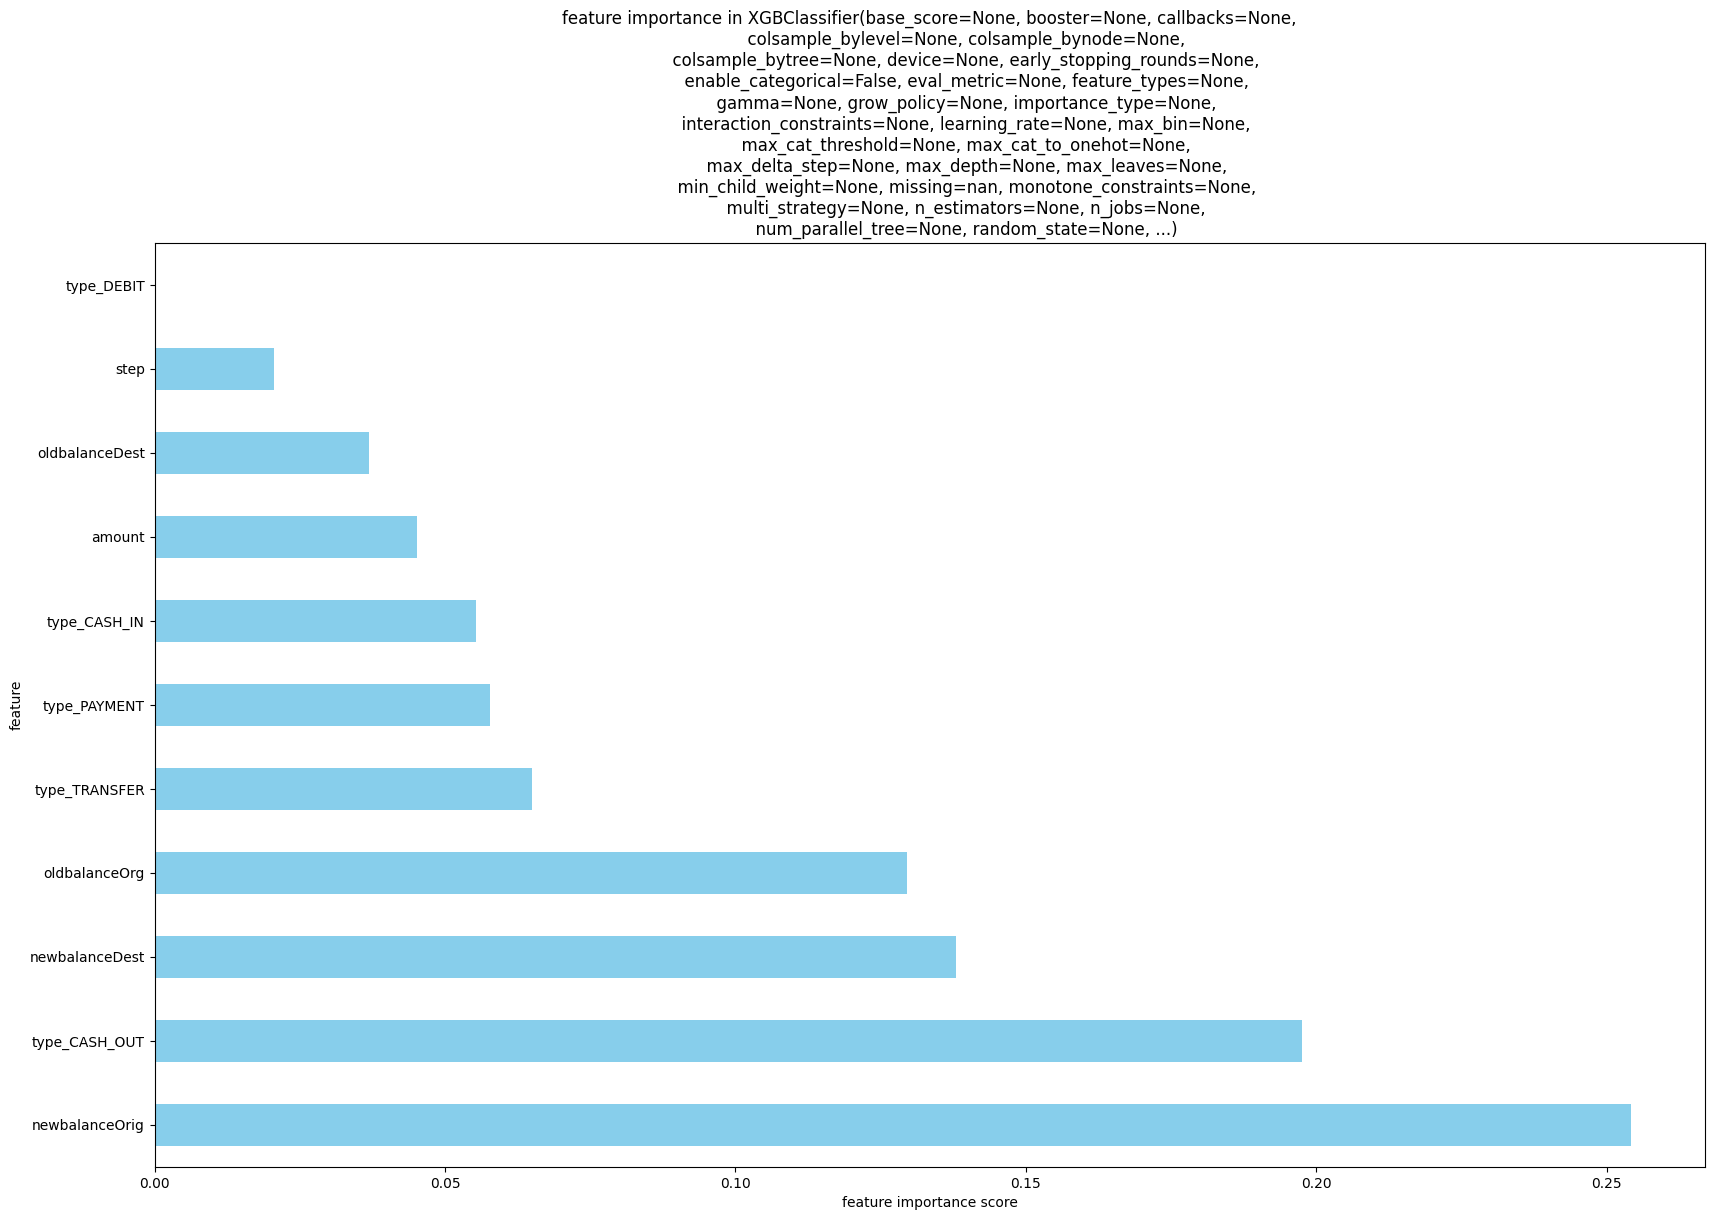

In [13]:
model = XGBClassifier()
model.fit(x_train , y_train)
plot_results(model , x_train  , x_test , y_test)

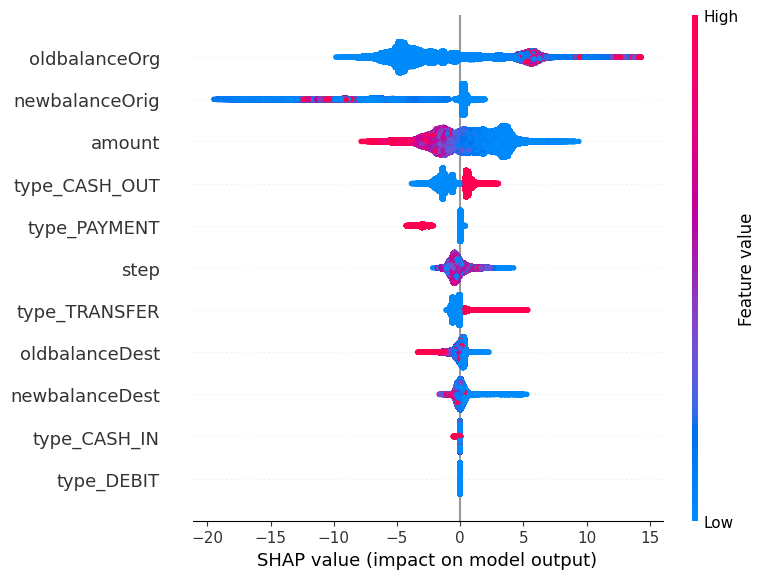

In [14]:
shap_plot(model , x_test)

In [15]:
# Train Data Evaluate
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.98      0.90      0.94      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.95      0.97   5090096
weighted avg       1.00      1.00      1.00   5090096



🐱 CatBoost Classifier Evaluation

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034471
0:	learn: 0.4964356	test: 0.4956790	best: 0.4956790 (0)	total: 135ms	remaining: 2m 14s
1:	learn: 0.3467314	test: 0.3351852	best: 0.4956790 (0)	total: 197ms	remaining: 1m 38s
2:	learn: 0.3852571	test: 0.3740741	best: 0.4956790 (0)	total: 259ms	remaining: 1m 25s
3:	learn: 0.3838920	test: 0.3753086	best: 0.4956790 (0)	total: 320ms	remaining: 1m 19s
4:	learn: 0.4257546	test: 0.4104938	best: 0.4956790 (0)	total: 382ms	remaining: 1m 16s
5:	learn: 0.3986046	test: 0.3888889	best: 0.4956790 (0)	total: 444ms	remaining: 1m 13s
6:	learn: 0.4070984	test: 0.3956790	best: 0.4956790 (0)	total: 505ms	remaining: 1m 11s
7:	learn: 0.4180191	test: 0.4043210	best: 0.4956790 (0)	total: 568ms	remaining: 1m 10s
8:	learn: 0.4180191	test: 0.4043210	best: 0.4956790 (0)	total: 631ms	remaining: 1m 9s
9:	learn: 0.4180191	test: 0.4043210	best: 0.4956790 (0)	total: 693ms	remaining: 1m 8s
10:	learn: 0.4205976	test: 0.4067901	best: 0.4956790 (0)	total: 755ms	remaining: 1m 7s
11:	learn: 0.44

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


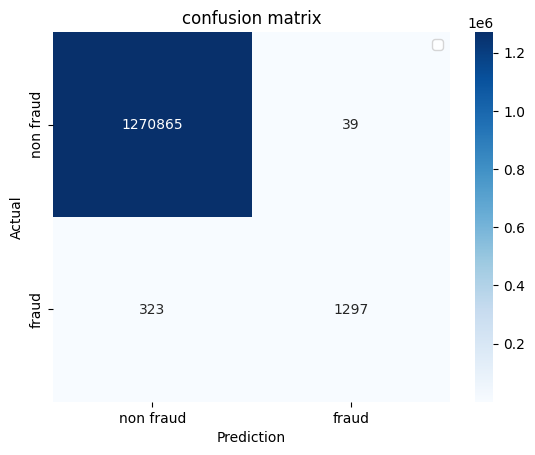

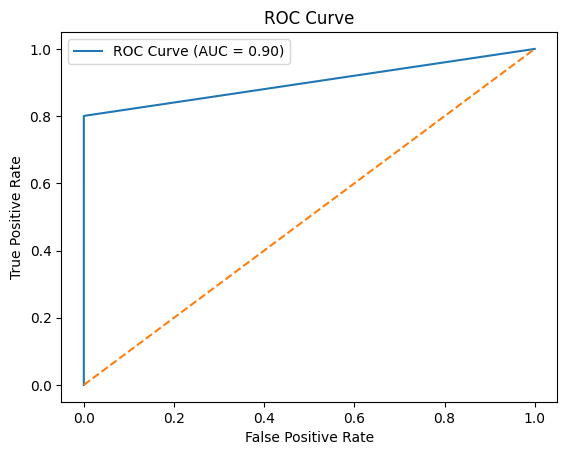

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.80      0.88      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



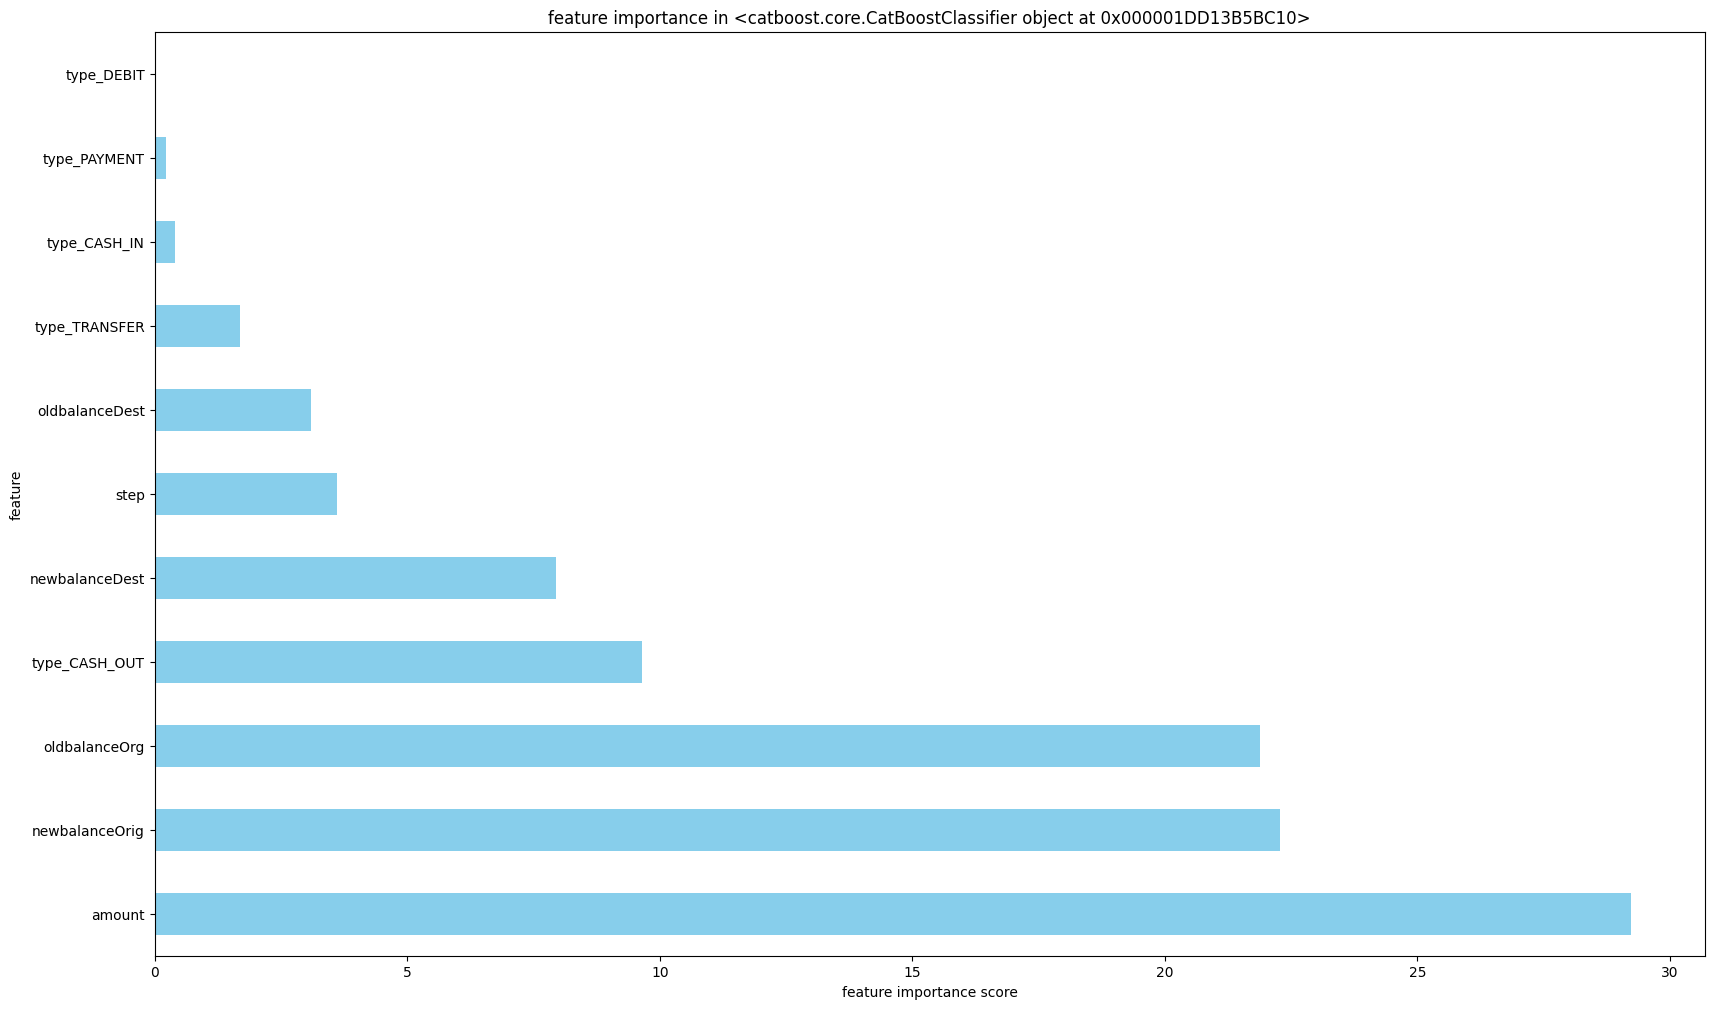

In [16]:
model = CatBoostClassifier(max_depth=5 , iterations=1000 , task_type='GPU' , eval_metric='Recall')
model.fit(x_train , y_train , eval_set=(x_test , y_test) , plot=True)
plot_results(model, x_train  , x_test , y_test)

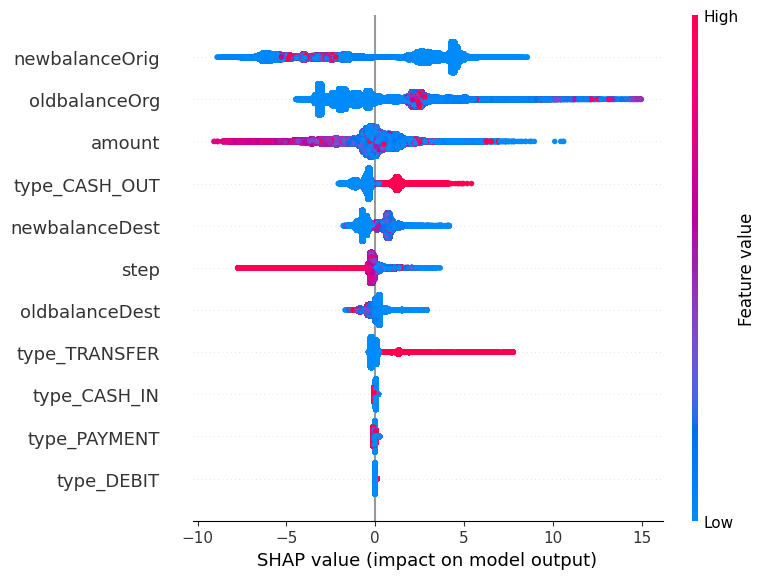

In [17]:
shap_plot(model , x_test)

In [18]:
# Train Data Evaluate
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.98      0.80      0.88      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.90      0.94   5090096
weighted avg       1.00      1.00      1.00   5090096



💡 LightGBM Classifier Evaluation

[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001295 -> initscore=-6.647747
[LightGBM] [Info] Start training from score -6.647747


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


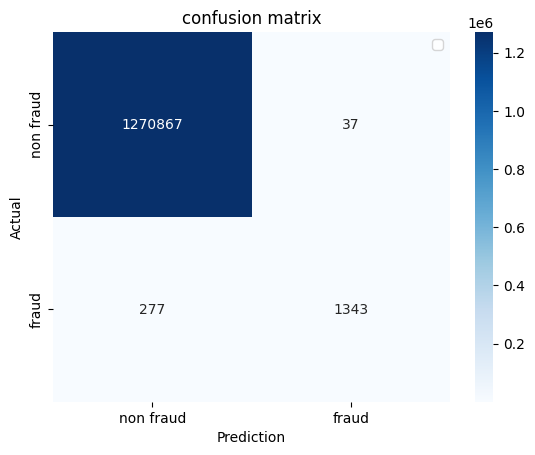

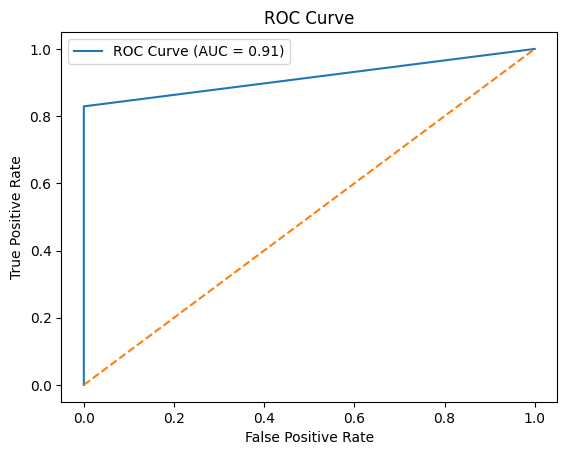

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.83      0.90      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



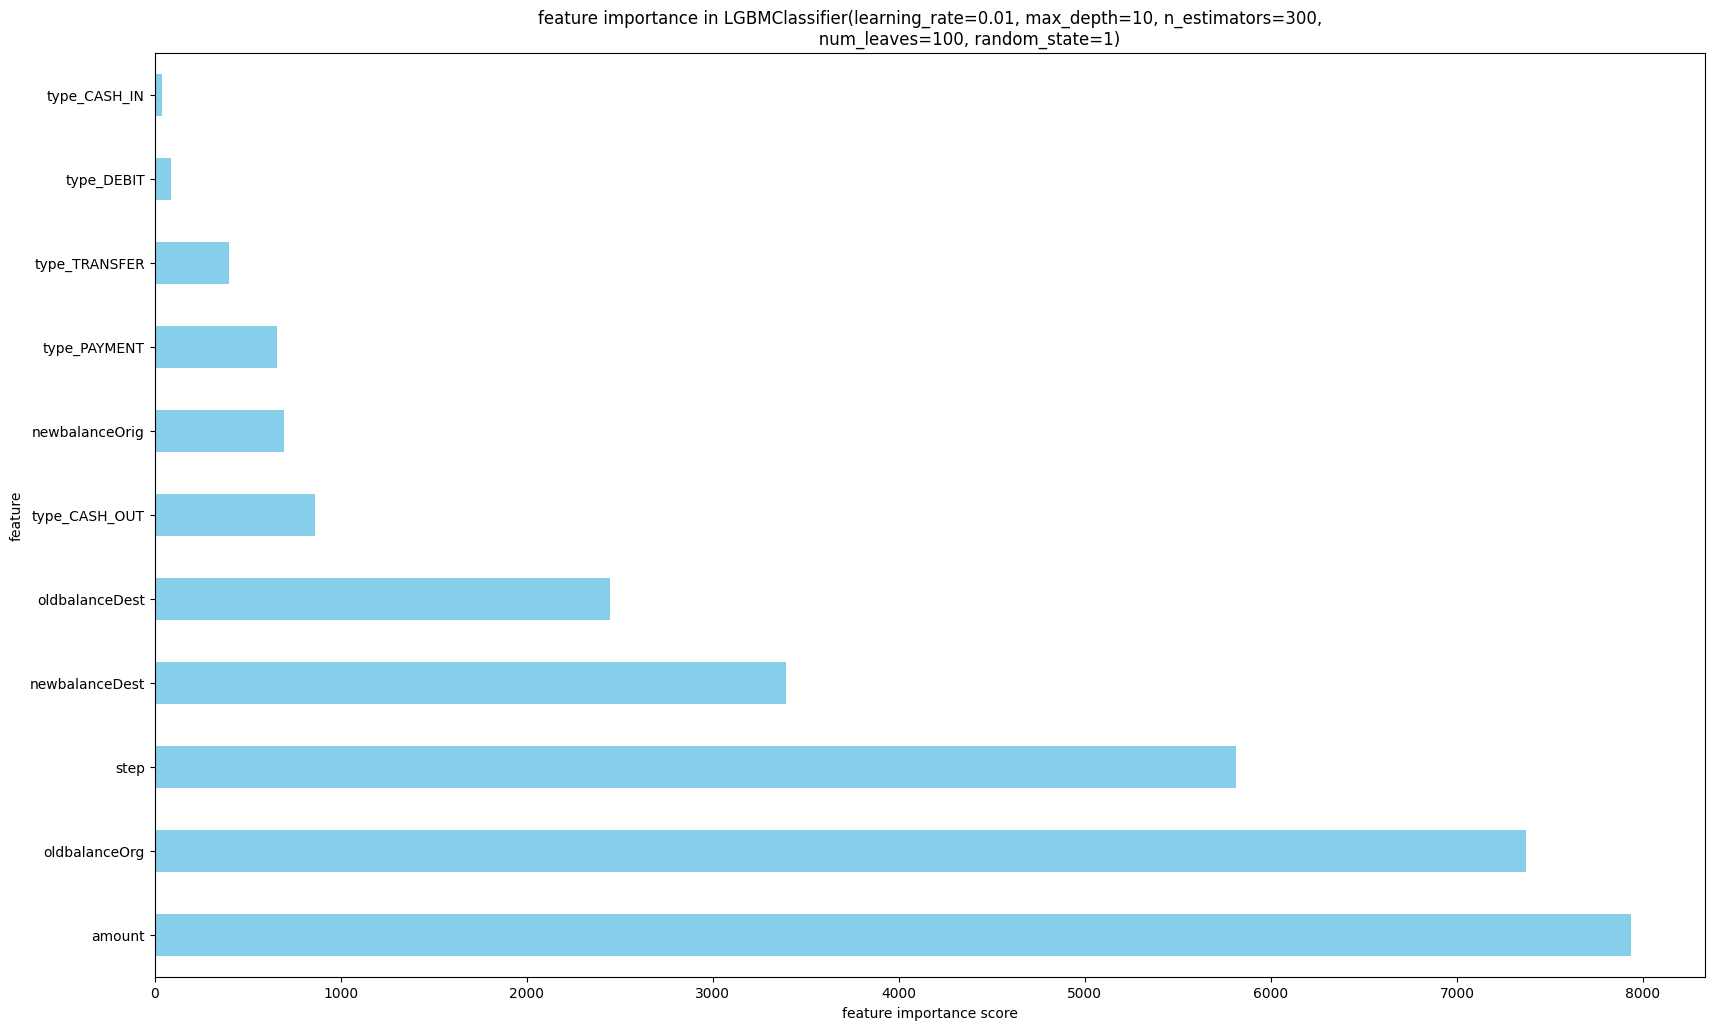

In [19]:
model = LGBMClassifier(n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1)
model.fit(x_train , y_train)
plot_results(model , x_train   , x_test , y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


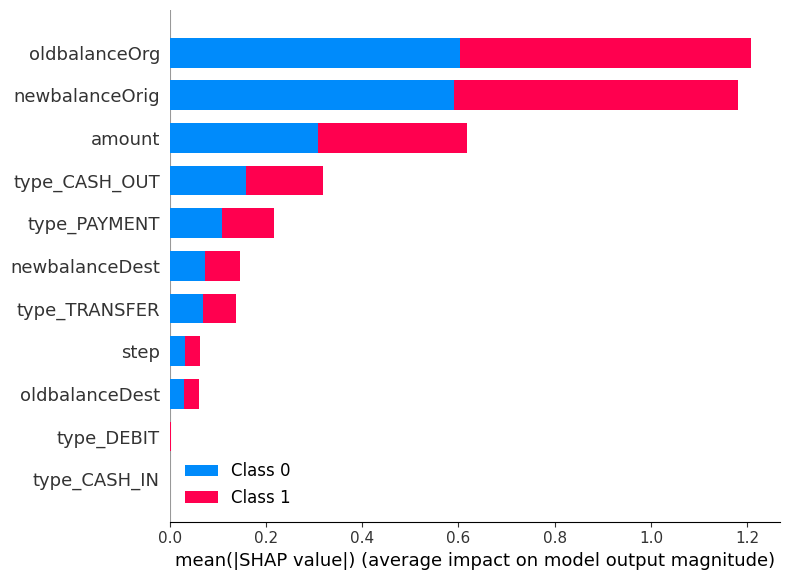

In [20]:
shap_plot(model , x_test)

In [21]:
# Train Data Evaluate
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.99      0.86      0.92      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.93      0.96   5090096
weighted avg       1.00      1.00      1.00   5090096



## 🧪 Phase 1: Baseline Model Evaluation (No Class Weighting)

In the initial phase of this fraud detection project, I trained four popular machine learning models without applying any class balancing techniques:

- Random Forest Classifier (RFC)  
- XGBoost  
- CatBoost  
- LightGBM

Due to the severe class imbalance in the dataset, the models tended to favor the majority class (non-fraud), resulting in poor performance on the minority class (fraud), especially in terms of recall and F1-score.

---

## ⚖️ Phase 2: Introducing Class Weights to Handle Imbalance

To improve detection of the minority class, I used compute_class_weight from sklearn.utils to assign higher weights to the fraud class. These weights were passed to models that support class weighting to penalize misclassification of rare events more severely.

This step aims to:
- Improve sensitivity (recall) for the fraud class  
- Enhance balanced accuracy and F1-score  
- Provide a more reliable fraud detection pipeline

Results from this phase will be compared against the baseline to evaluate the impact of class balancing.

##### 🏗️ Computing Class Weights
I calculated class weights using compute_class_weight from sklearn.utils.class_weight to handle the class imbalance problem. These weights were then passed to models that support class weighting.

In [7]:
# class weights
weight = compute_class_weight(class_weight='balanced' , classes = np.unique(y_train) , y=y_train)
class_weight = dict(zip(np.unique(y_train) , weight))
class_weight

{0: 0.5006484701592583, 1: 386.0227514030032}

##### 🌲Random Forest with Class Weights
Trained a Random Forest model with the computed class weights.
The results were visualized using the plot_results function to evaluate performance on the test set, focusing on improvements in fraud detection.

#### 🚀 XGBoost with Class Weights

[16:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


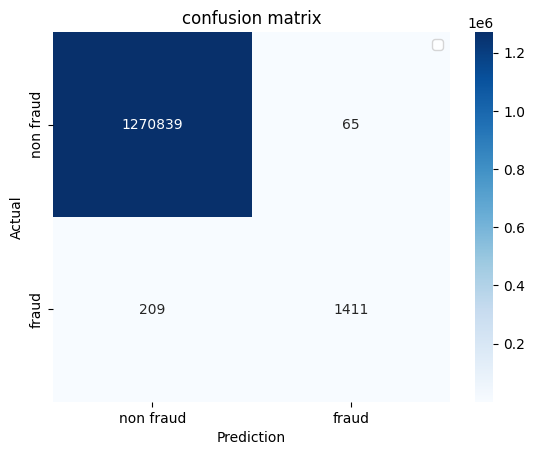

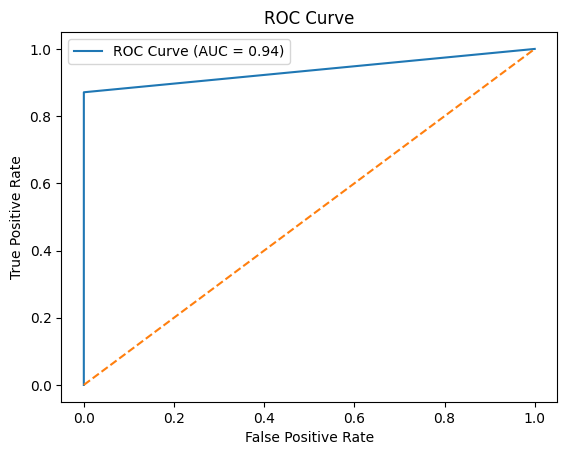

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.87      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.94      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



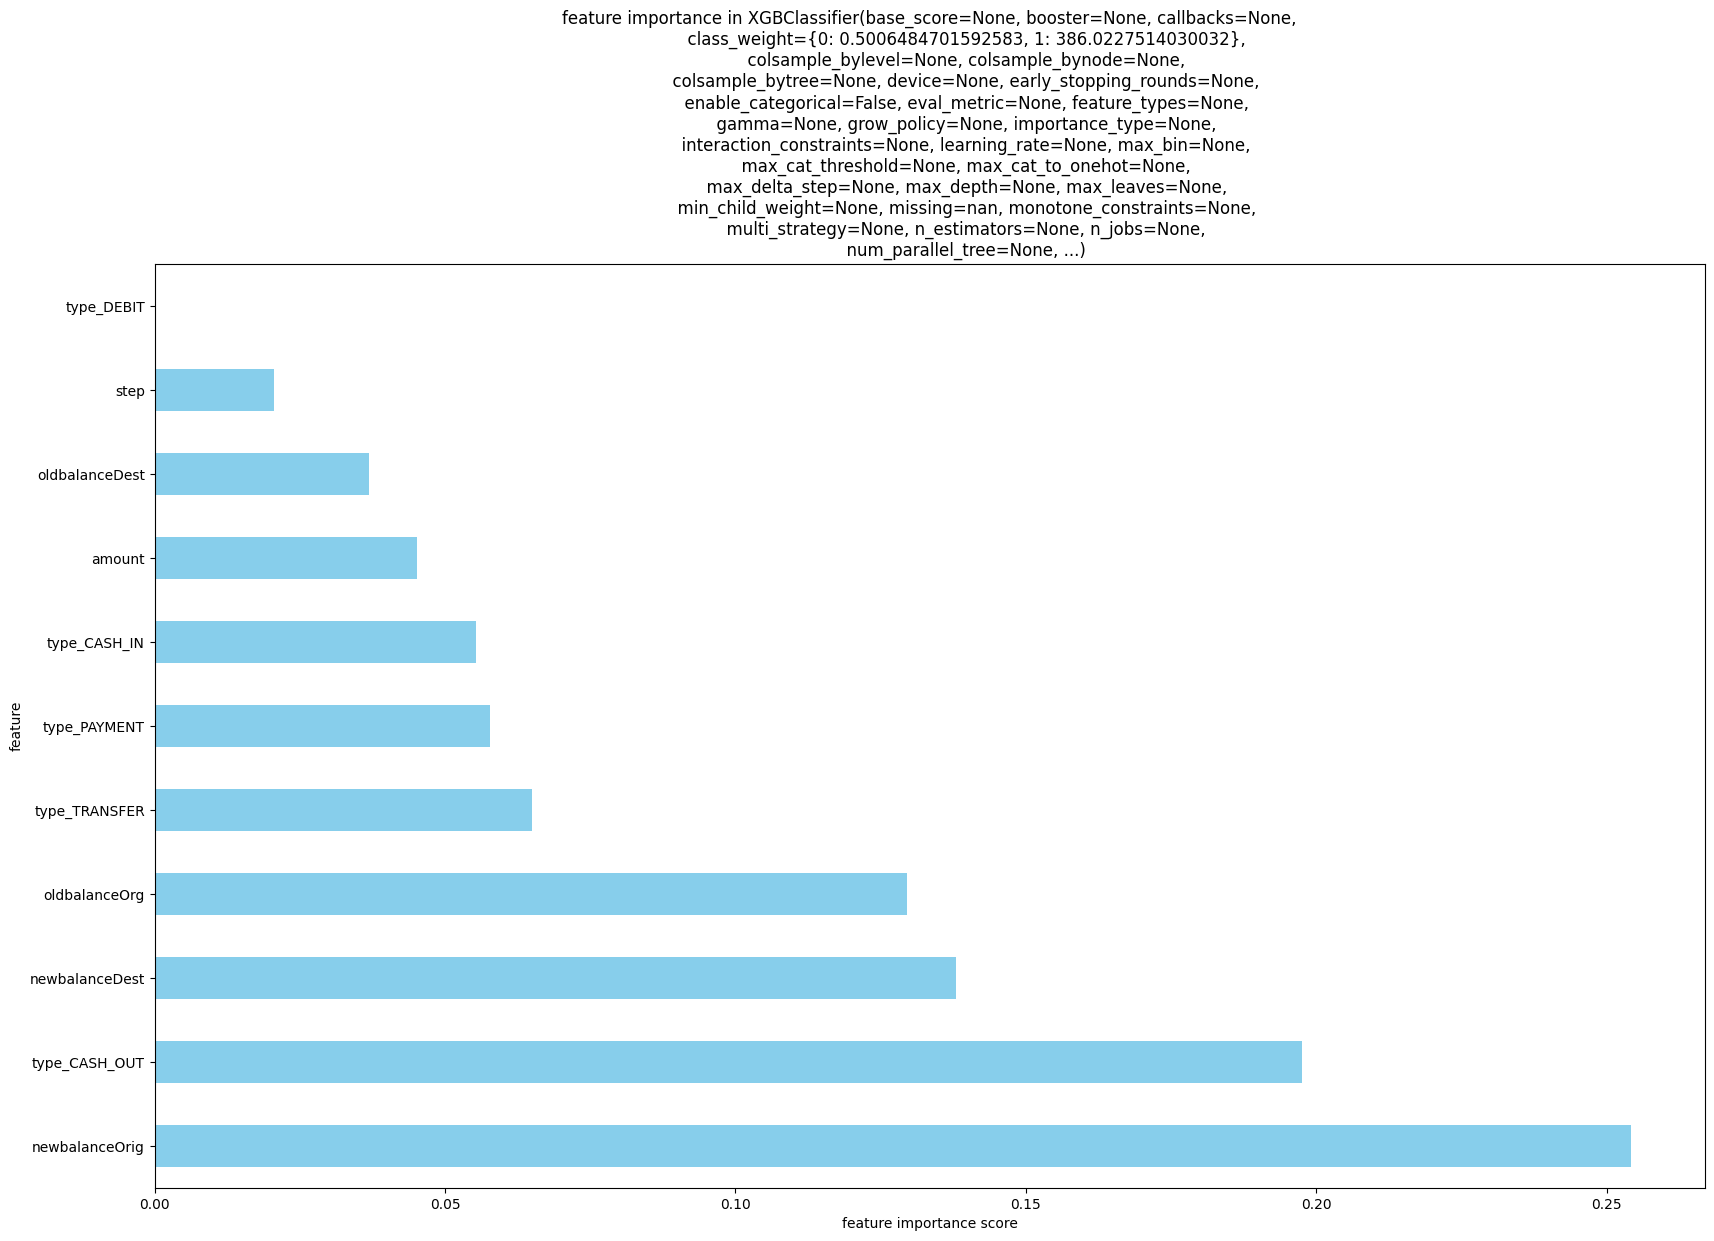

In [23]:
model = XGBClassifier(class_weight=class_weight)
model.fit(x_train , y_train)
plot_results(model , x_train   , x_test , y_test)

In [24]:
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.98      0.90      0.94      6593

    accuracy                           1.00   5090096
   macro avg       0.99      0.95      0.97   5090096
weighted avg       1.00      1.00      1.00   5090096



#### 🐱  CatBoost with Class Weights

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034471
0:	learn: 0.9918095	test: 0.9913580	best: 0.9913580 (0)	total: 62.6ms	remaining: 1m 2s
1:	learn: 0.9881693	test: 0.9876543	best: 0.9913580 (0)	total: 126ms	remaining: 1m 2s
2:	learn: 0.9884726	test: 0.9876543	best: 0.9913580 (0)	total: 189ms	remaining: 1m 2s
3:	learn: 0.9880176	test: 0.9870370	best: 0.9913580 (0)	total: 252ms	remaining: 1m 2s
4:	learn: 0.9899894	test: 0.9907407	best: 0.9913580 (0)	total: 314ms	remaining: 1m 2s
5:	learn: 0.9902927	test: 0.9907407	best: 0.9913580 (0)	total: 376ms	remaining: 1m 2s
6:	learn: 0.9902927	test: 0.9907407	best: 0.9913580 (0)	total: 441ms	remaining: 1m 2s
7:	learn: 0.9902927	test: 0.9907407	best: 0.9913580 (0)	total: 504ms	remaining: 1m 2s
8:	learn: 0.9905961	test: 0.9907407	best: 0.9913580 (0)	total: 567ms	remaining: 1m 2s
9:	learn: 0.9895344	test: 0.9888889	best: 0.9913580 (0)	total: 630ms	remaining: 1m 2s
10:	learn: 0.9889277	test: 0.9876543	best: 0.9913580 (0)	total: 693ms	remaining: 1m 2s
11:	learn: 0.9807371	t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


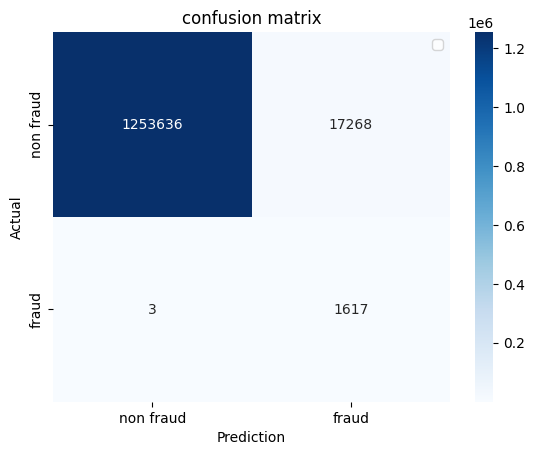

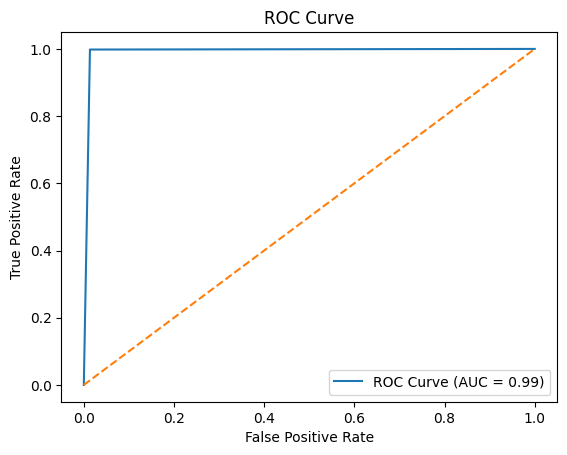

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.09      1.00      0.16      1620

    accuracy                           0.99   1272524
   macro avg       0.54      0.99      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524



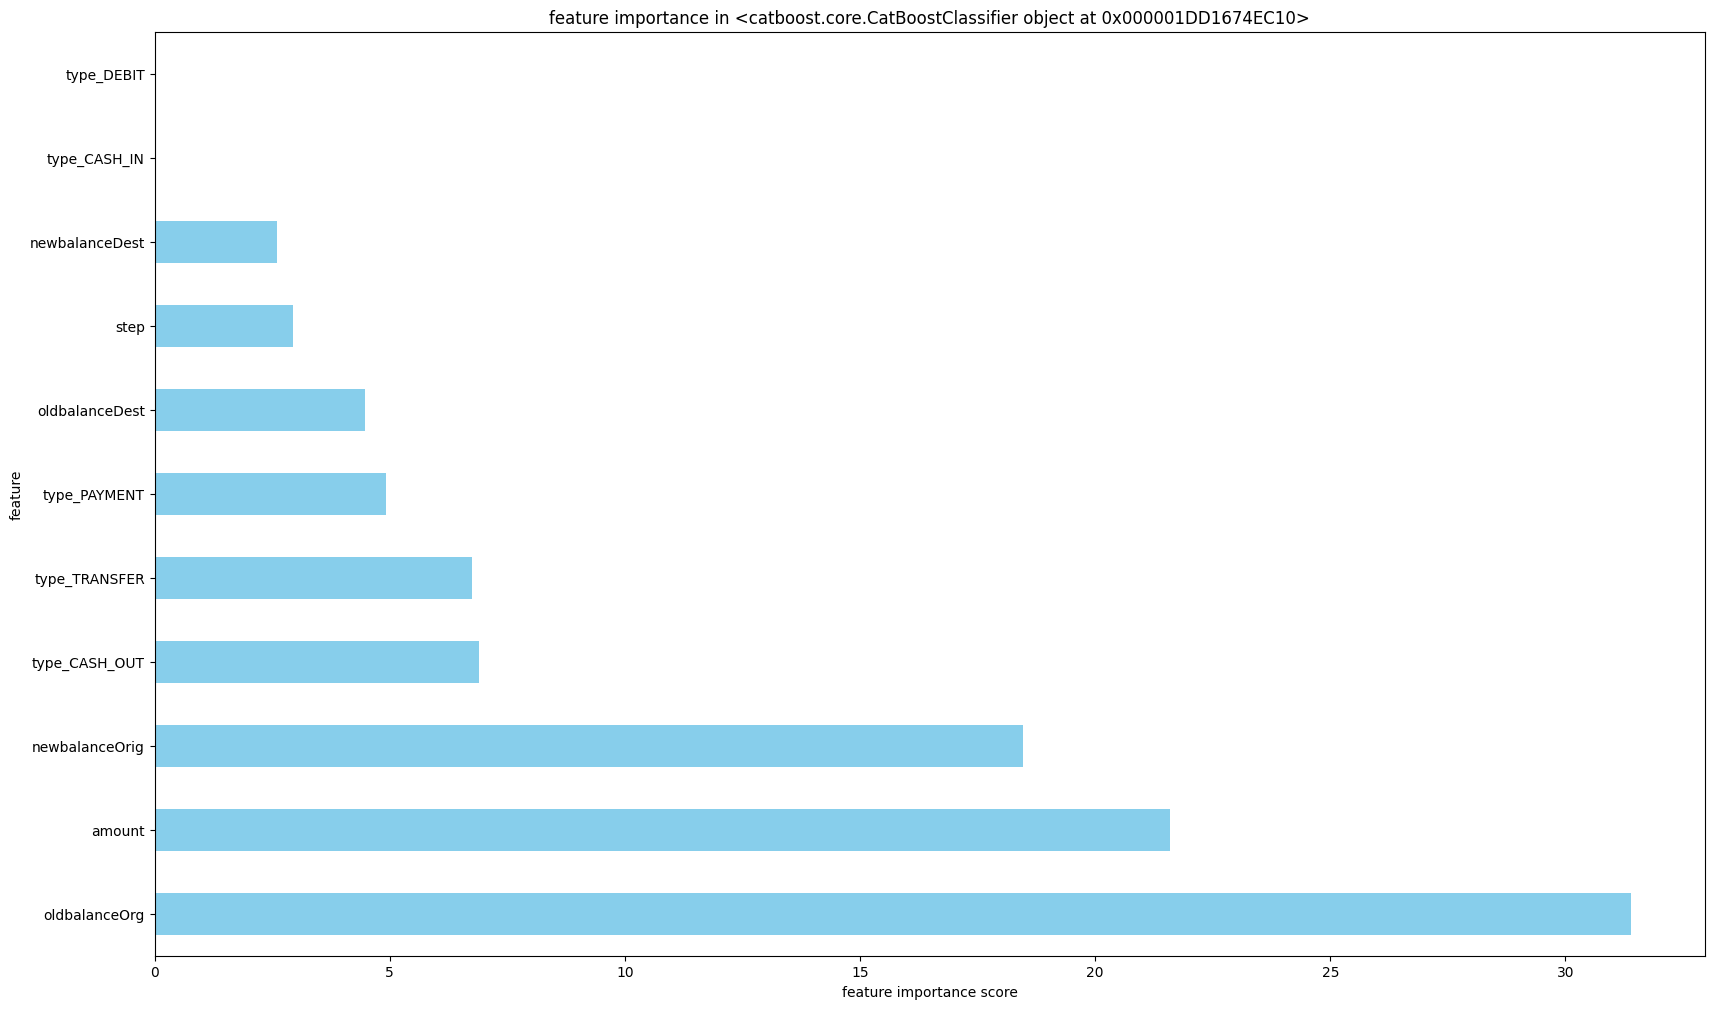

In [25]:
model = CatBoostClassifier(max_depth=5 , iterations=1000 , task_type='GPU' , eval_metric='Recall' , class_weights=class_weight)
model.fit(x_train , y_train , eval_set=(x_test , y_test) , plot=True)
plot_results(model , x_train   , x_test , y_test)

In [26]:
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   5083503
           1       0.09      1.00      0.16      6593

    accuracy                           0.99   5090096
   macro avg       0.54      0.99      0.58   5090096
weighted avg       1.00      0.99      0.99   5090096



#### 💡  LightGBM with Class Weights

[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


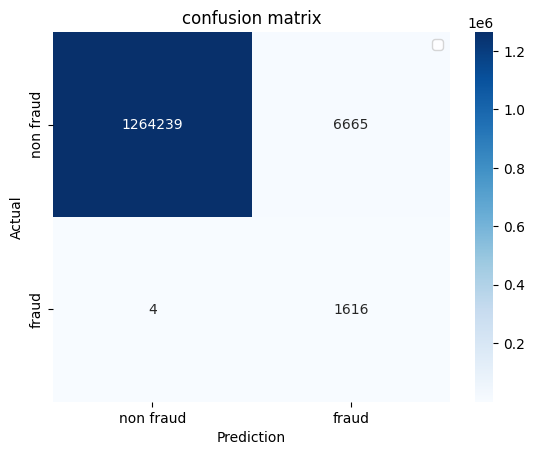

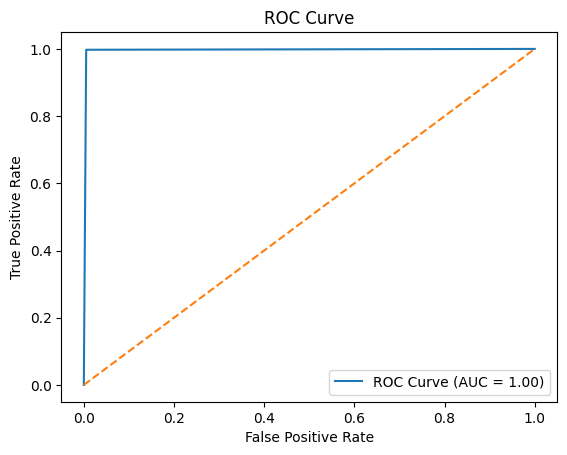

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.20      1.00      0.33      1620

    accuracy                           0.99   1272524
   macro avg       0.60      1.00      0.66   1272524
weighted avg       1.00      0.99      1.00   1272524



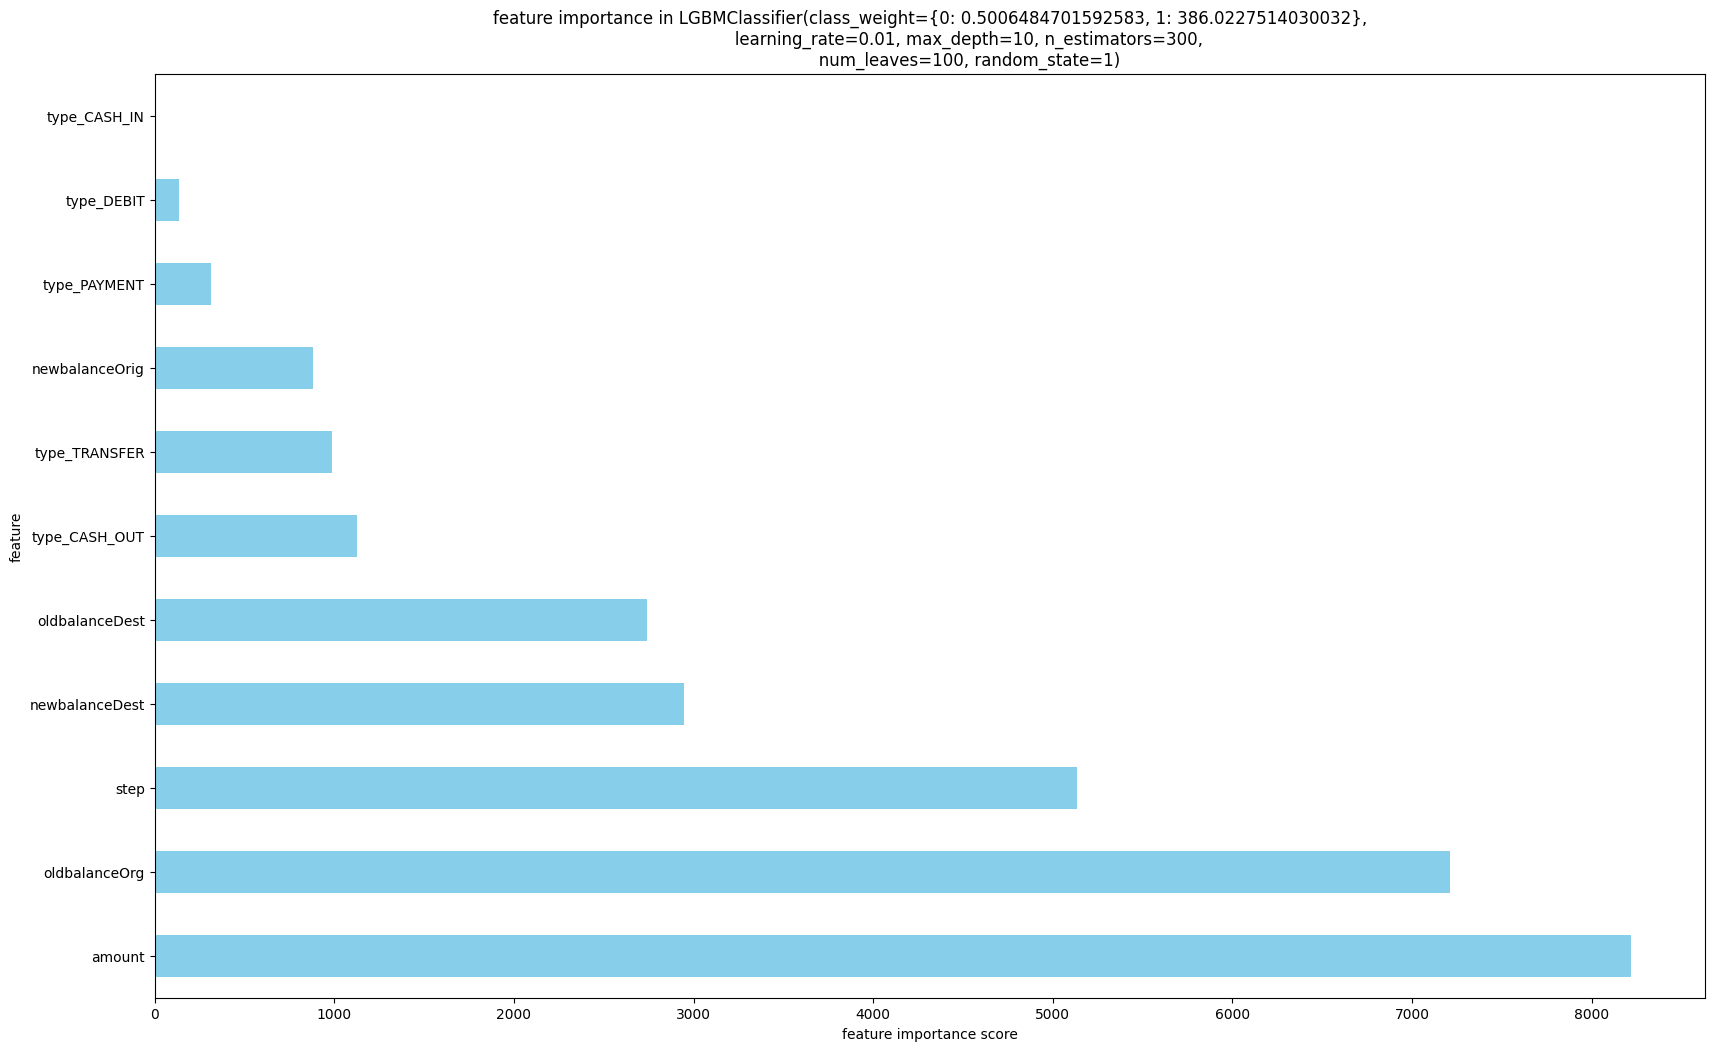

In [27]:
model = LGBMClassifier(n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1 , class_weight=class_weight)
model.fit(x_train , y_train)
plot_results(model , x_train   , x_test , y_test)

In [28]:
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083503
           1       0.20      1.00      0.33      6593

    accuracy                           0.99   5090096
   macro avg       0.60      1.00      0.67   5090096
weighted avg       1.00      0.99      1.00   5090096



### 🔄 Phase 3: Addressing Imbalance with SMOTE Oversampling

After applying class weighting in Phase 2, although recall for the minority (fraud) class improved, the precision dropped significantly — indicating a high number of false positives.

To tackle this issue, I introduced SMOTE (Synthetic Minority Oversampling Technique) to synthetically generate new samples for the minority class and balance the dataset.

In this phase, I retrained the following three models *(excluding Random Forest due to its slow training time)*:

- XGBoost  
- CatBoost  
- LightGBM

The goals of this phase were to:

- Further improve model sensitivity to fraudulent transactions  
- Reduce false positives and regain lost precision  
- Achieve a better F1-score and maintain a strong precision-recall tradeoff

📊 Results from this phase were compared to earlier stages to assess the impact of SMOTE on performance, especially for the minority class.

In [29]:
sm = SMOTE(n_jobs=-1 , k_neighbors=3)
x_train_sm , y_train_sm = sm.fit_resample(x_train , y_train)
x_train_sm.shape

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.


(10167006, 11)

#### 🐱  CatBoost with SMOTE

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.032502
0:	learn: 0.9940850	test: 0.9808642	best: 0.9808642 (0)	total: 116ms	remaining: 1m 56s
1:	learn: 0.9950491	test: 0.9876543	best: 0.9876543 (1)	total: 233ms	remaining: 1m 56s
2:	learn: 0.9950491	test: 0.9876543	best: 0.9876543 (1)	total: 349ms	remaining: 1m 56s
3:	learn: 0.9949645	test: 0.9876543	best: 0.9876543 (1)	total: 465ms	remaining: 1m 55s
4:	learn: 0.9949541	test: 0.9876543	best: 0.9876543 (1)	total: 579ms	remaining: 1m 55s
5:	learn: 0.9951295	test: 0.9876543	best: 0.9876543 (1)	total: 695ms	remaining: 1m 55s
6:	learn: 0.9829104	test: 0.9709877	best: 0.9876543 (1)	total: 811ms	remaining: 1m 55s
7:	learn: 0.9829108	test: 0.9709877	best: 0.9876543 (1)	total: 927ms	remaining: 1m 54s
8:	learn: 0.9828355	test: 0.9709877	best: 0.9876543 (1)	total: 1.04s	remaining: 1m 54s
9:	learn: 0.9829446	test: 0.9709877	best: 0.9876543 (1)	total: 1.16s	remaining: 1m 54s
10:	learn: 0.9828063	test: 0.9709877	best: 0.9876543 (1)	total: 1.27s	remaining: 1m 54s
11:	learn: 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


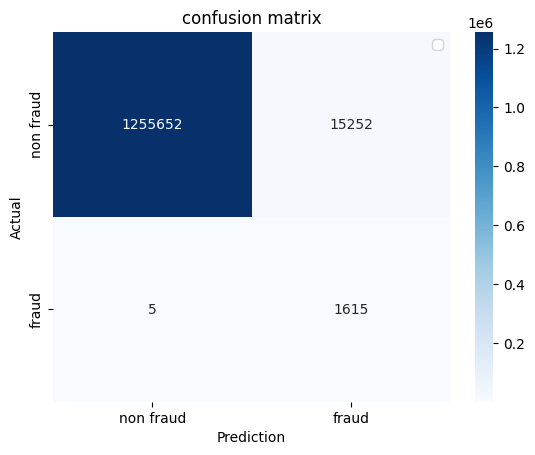

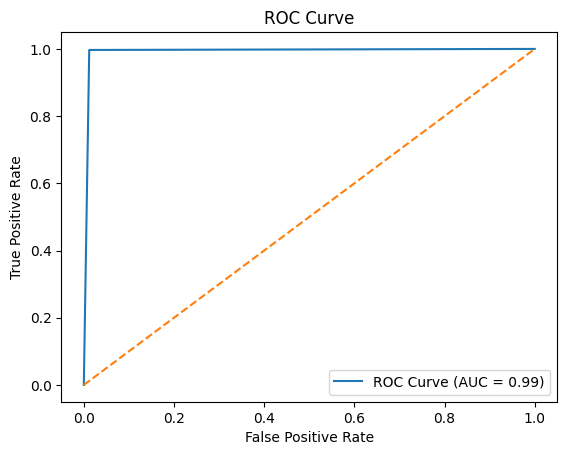

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.10      1.00      0.17      1620

    accuracy                           0.99   1272524
   macro avg       0.55      0.99      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524



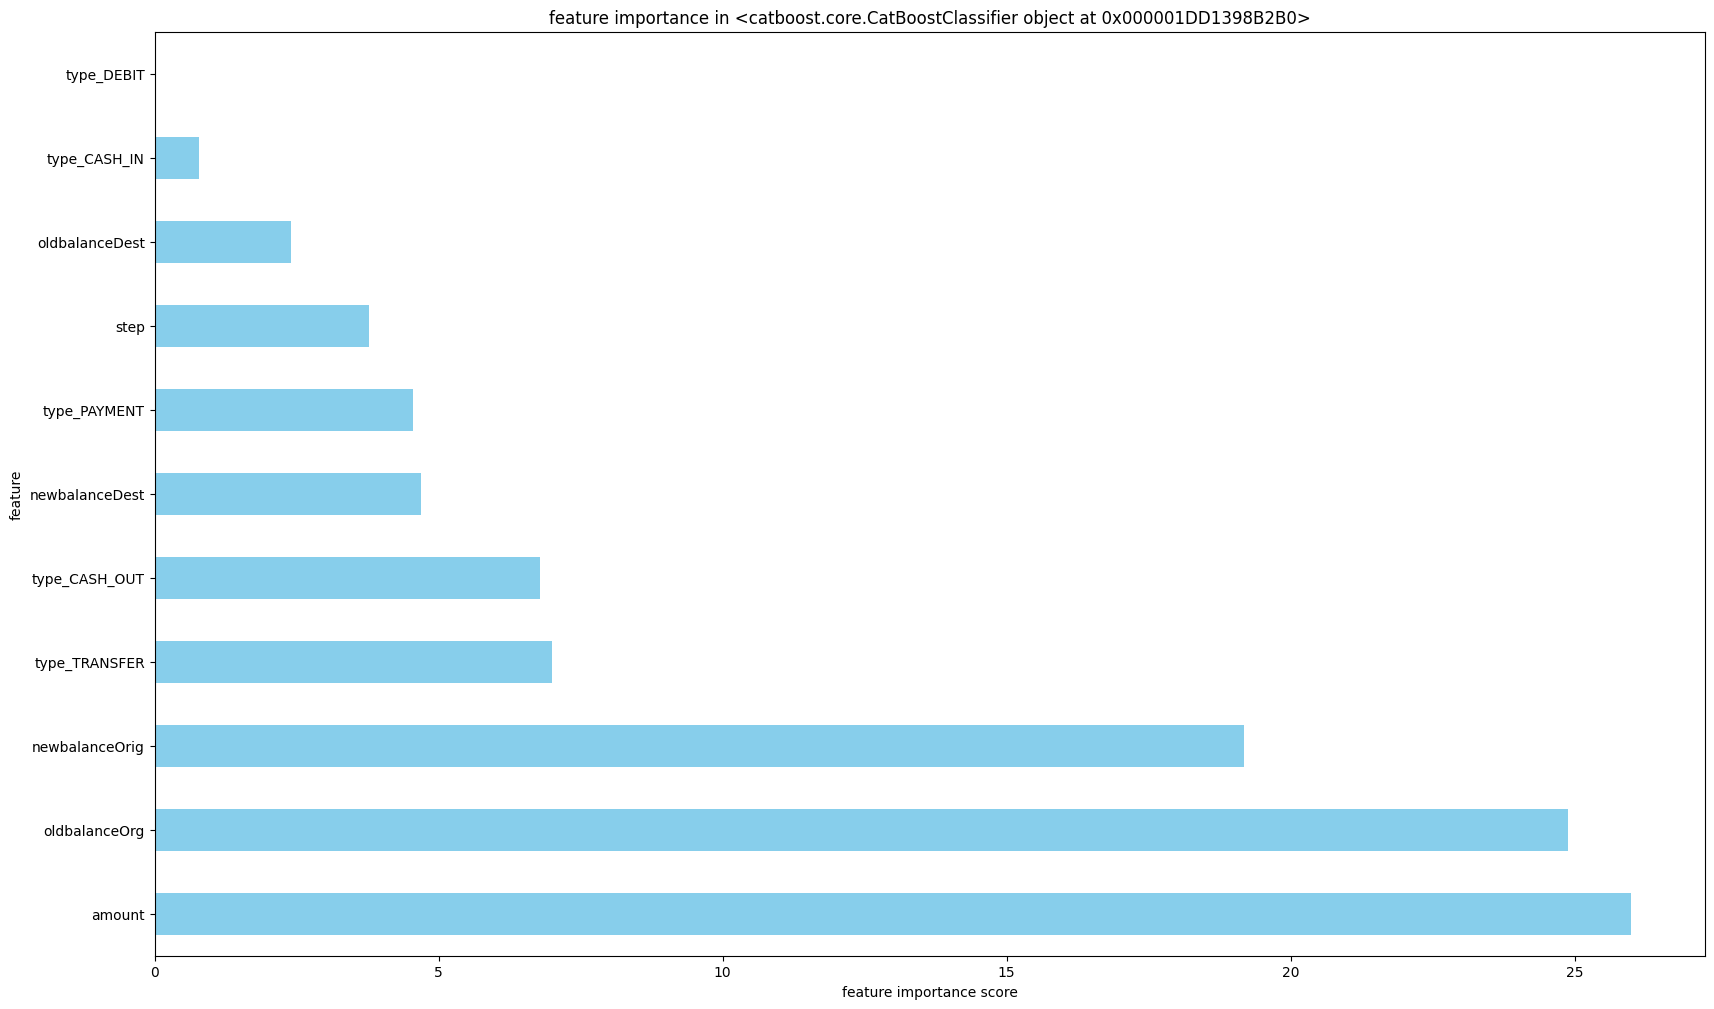

In [30]:
model = CatBoostClassifier(max_depth=5 , iterations=1000 , task_type='GPU' , eval_metric='Recall')
model.fit(x_train_sm , y_train_sm , eval_set=(x_test , y_test) , plot=True)
plot_results(model , x_train_sm   , x_test , y_test)

#### 🚀  XGBoost with SMOTE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


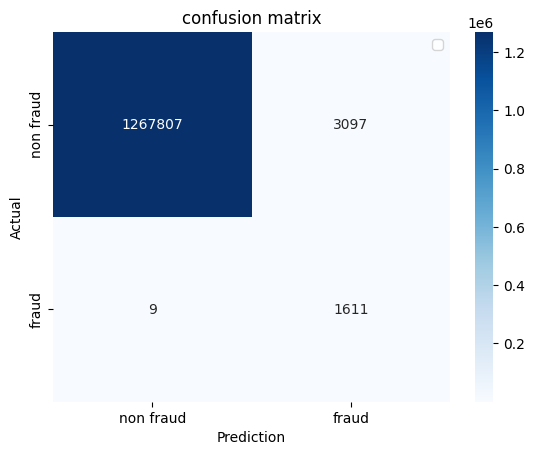

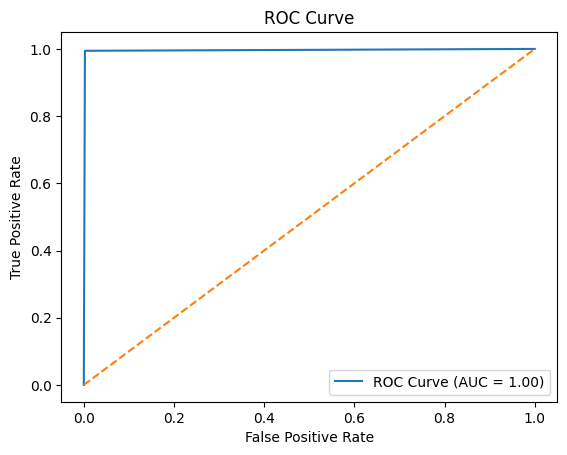

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.34      0.99      0.51      1620

    accuracy                           1.00   1272524
   macro avg       0.67      1.00      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524



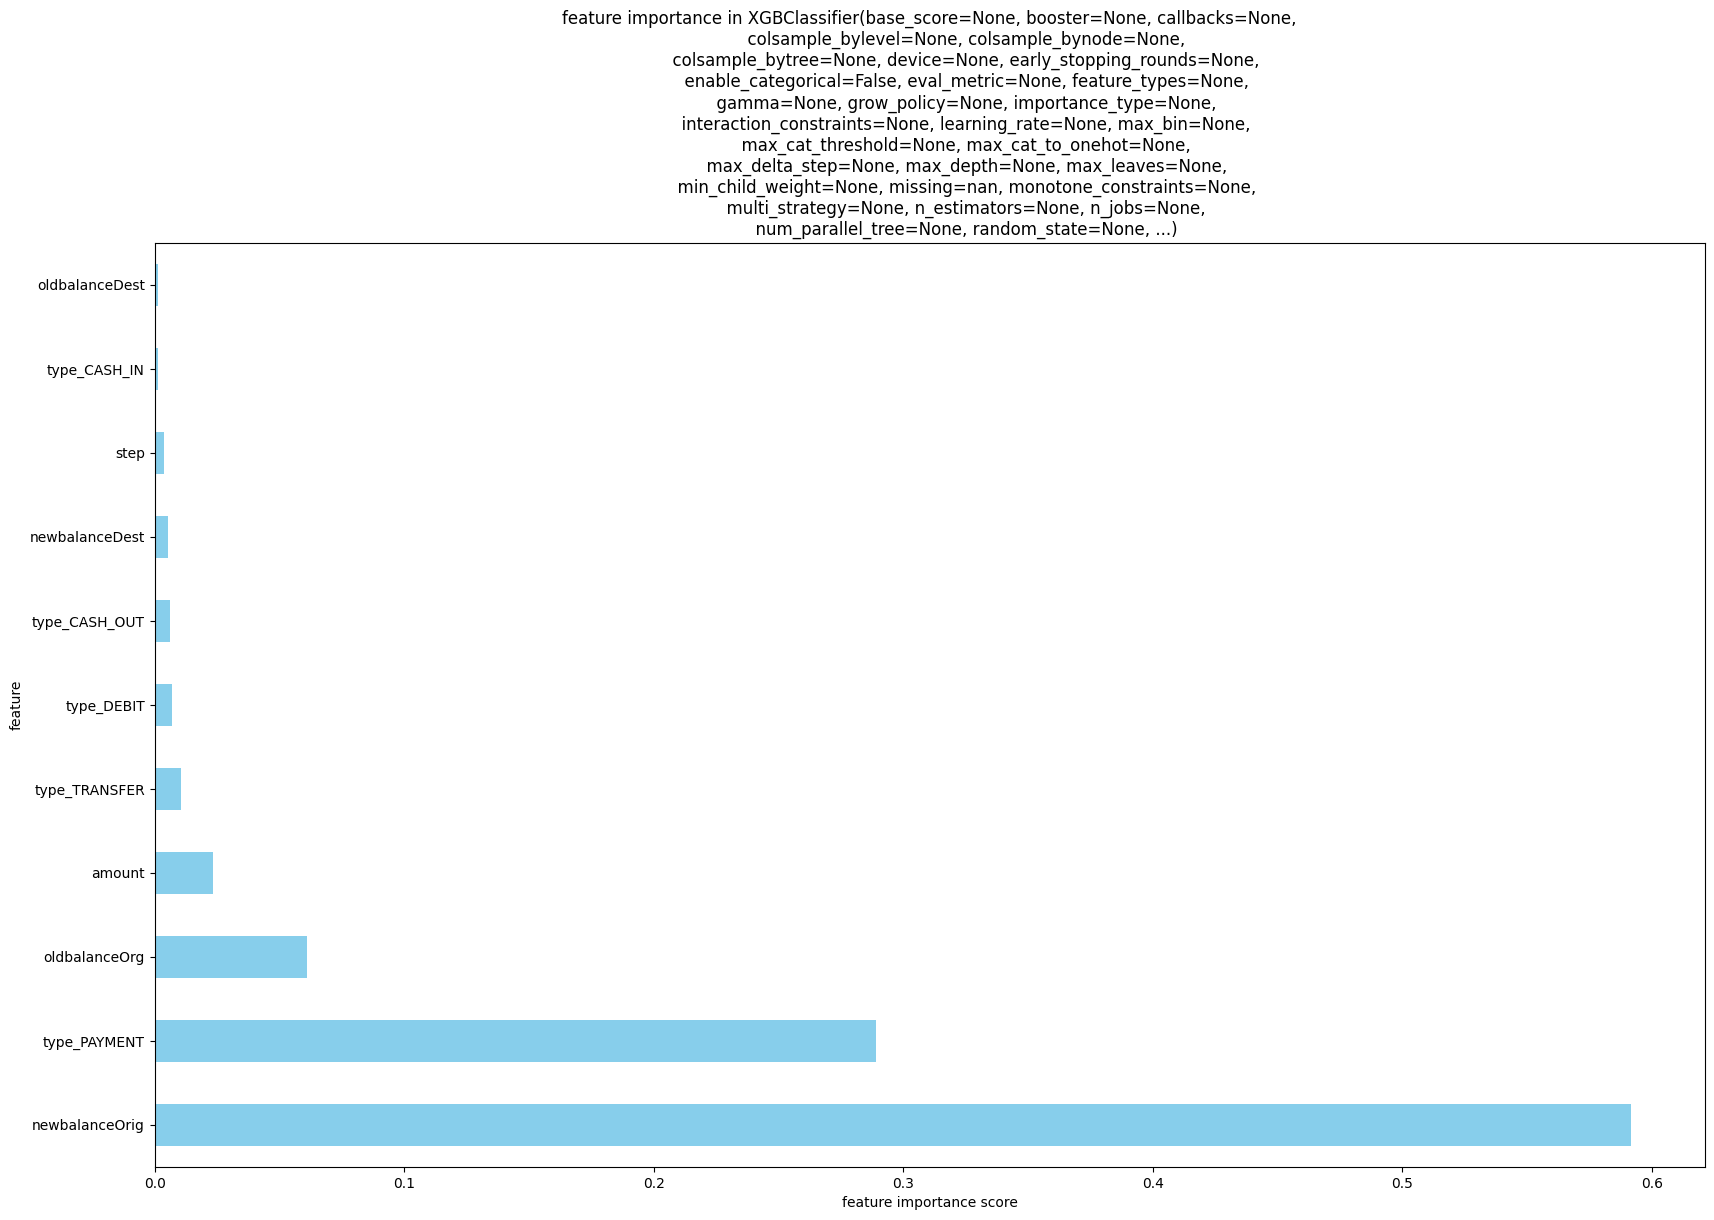

In [31]:
model = XGBClassifier()
model.fit(x_train_sm , y_train_sm)
plot_results(model , x_train_sm   , x_test , y_test)

In [32]:
y_pred = model.predict(x_train_sm)
print(classification_report(y_train_sm , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       1.00      1.00      1.00   5083503

    accuracy                           1.00  10167006
   macro avg       1.00      1.00      1.00  10167006
weighted avg       1.00      1.00      1.00  10167006



#### 💡  LightGBM with SMOTE

[LightGBM] [Info] Number of positive: 5083503, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 10167006, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


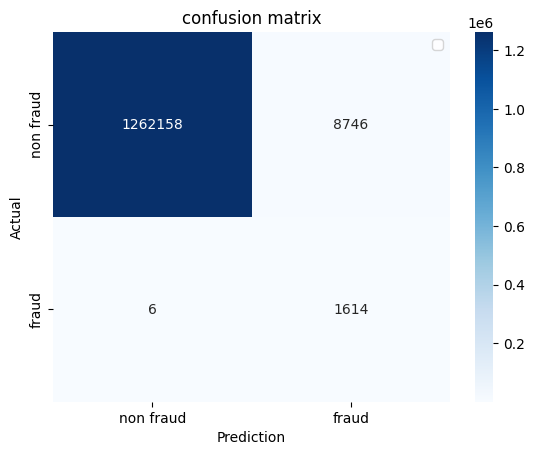

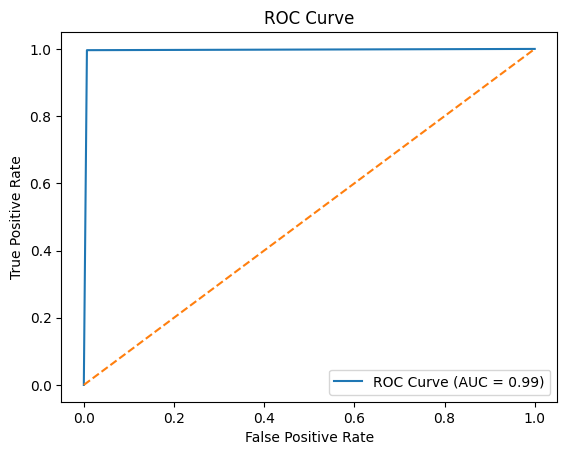

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.16      1.00      0.27      1620

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524



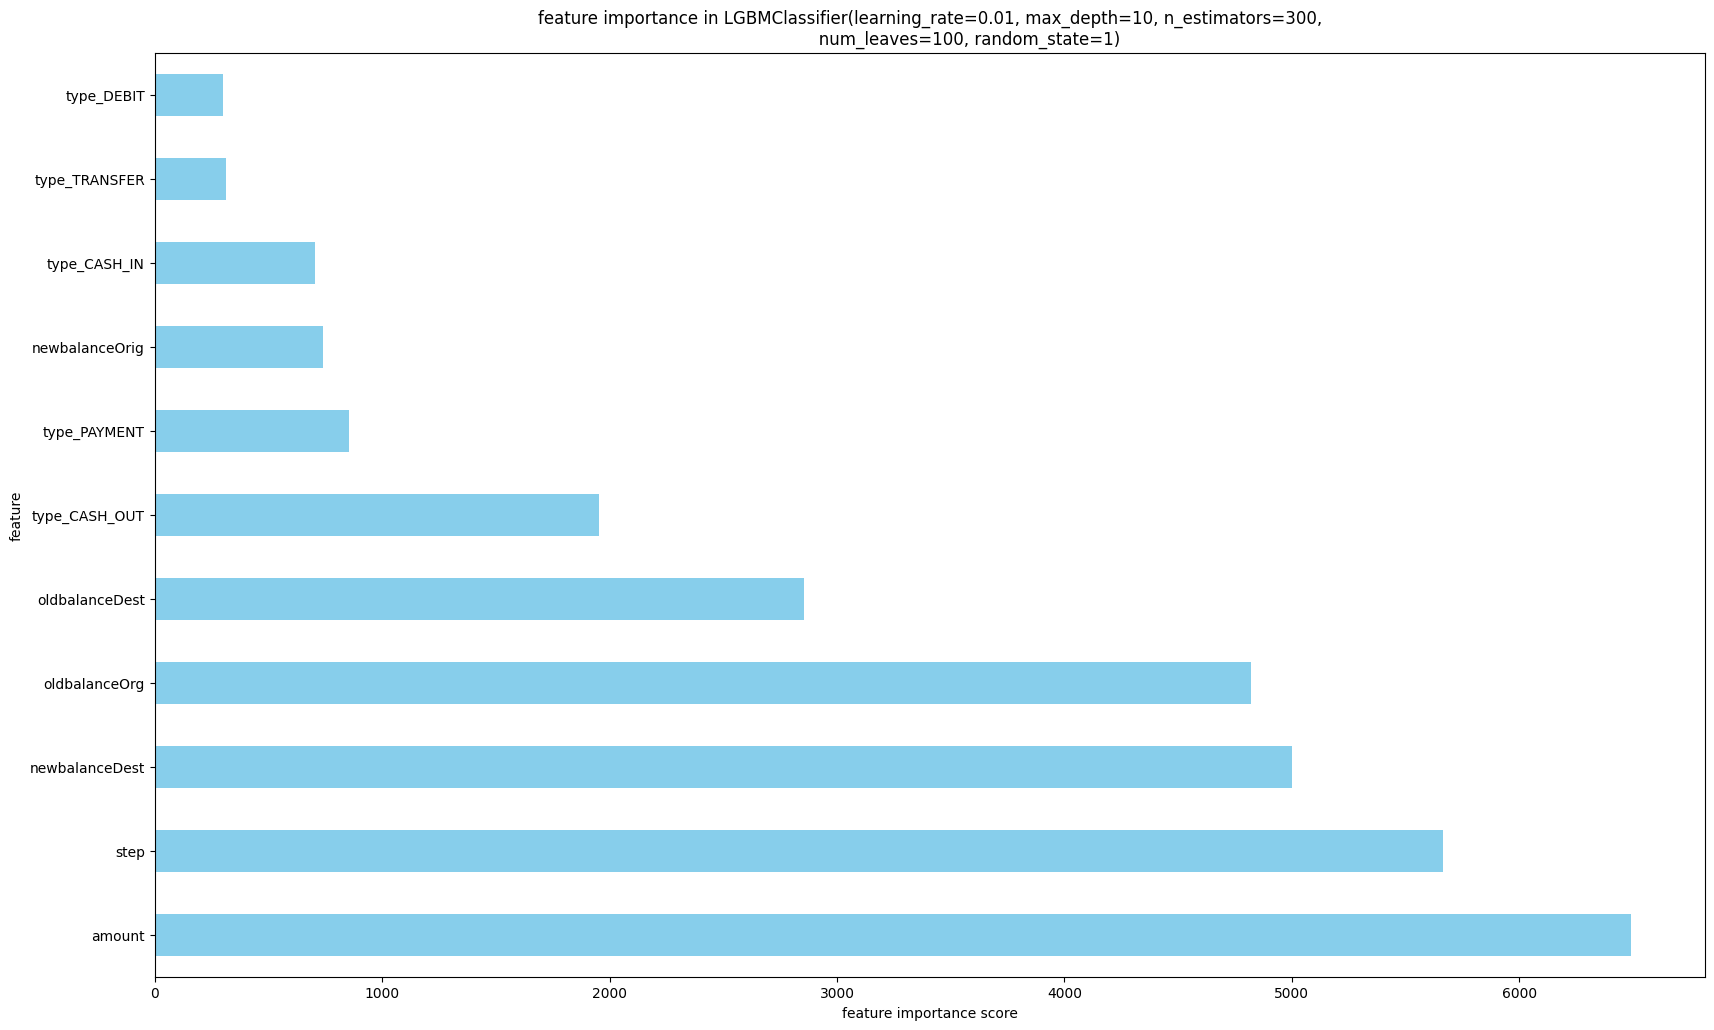

In [33]:
model = LGBMClassifier(n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1)
model.fit(x_train_sm , y_train_sm)
plot_results(model , x_train_sm   , x_test , y_test)

In [34]:
y_pred = model.predict(x_train_sm)
print(classification_report(y_train_sm , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083503
           1       0.99      1.00      1.00   5083503

    accuracy                           1.00  10167006
   macro avg       1.00      1.00      1.00  10167006
weighted avg       1.00      1.00      1.00  10167006



try with class_weight='balamced'

[16:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


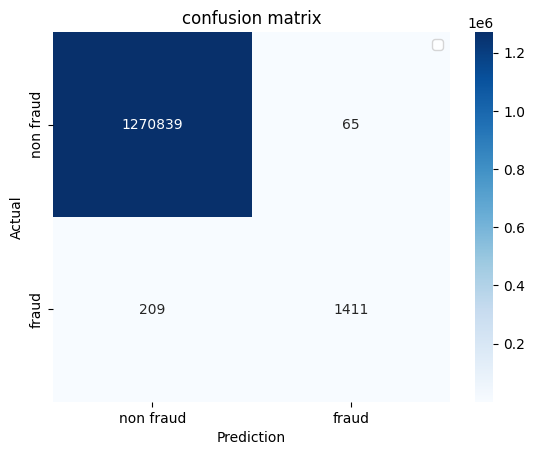

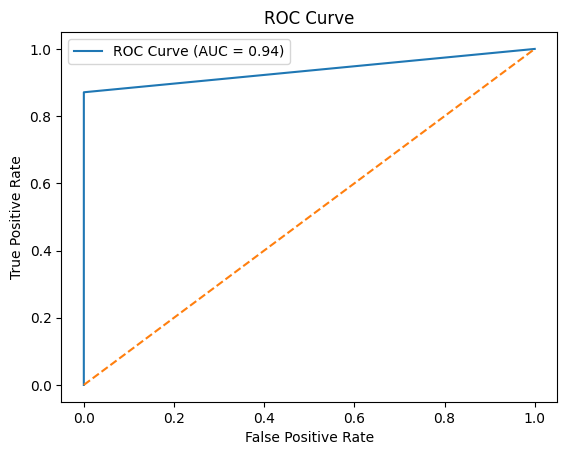

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.87      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.94      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



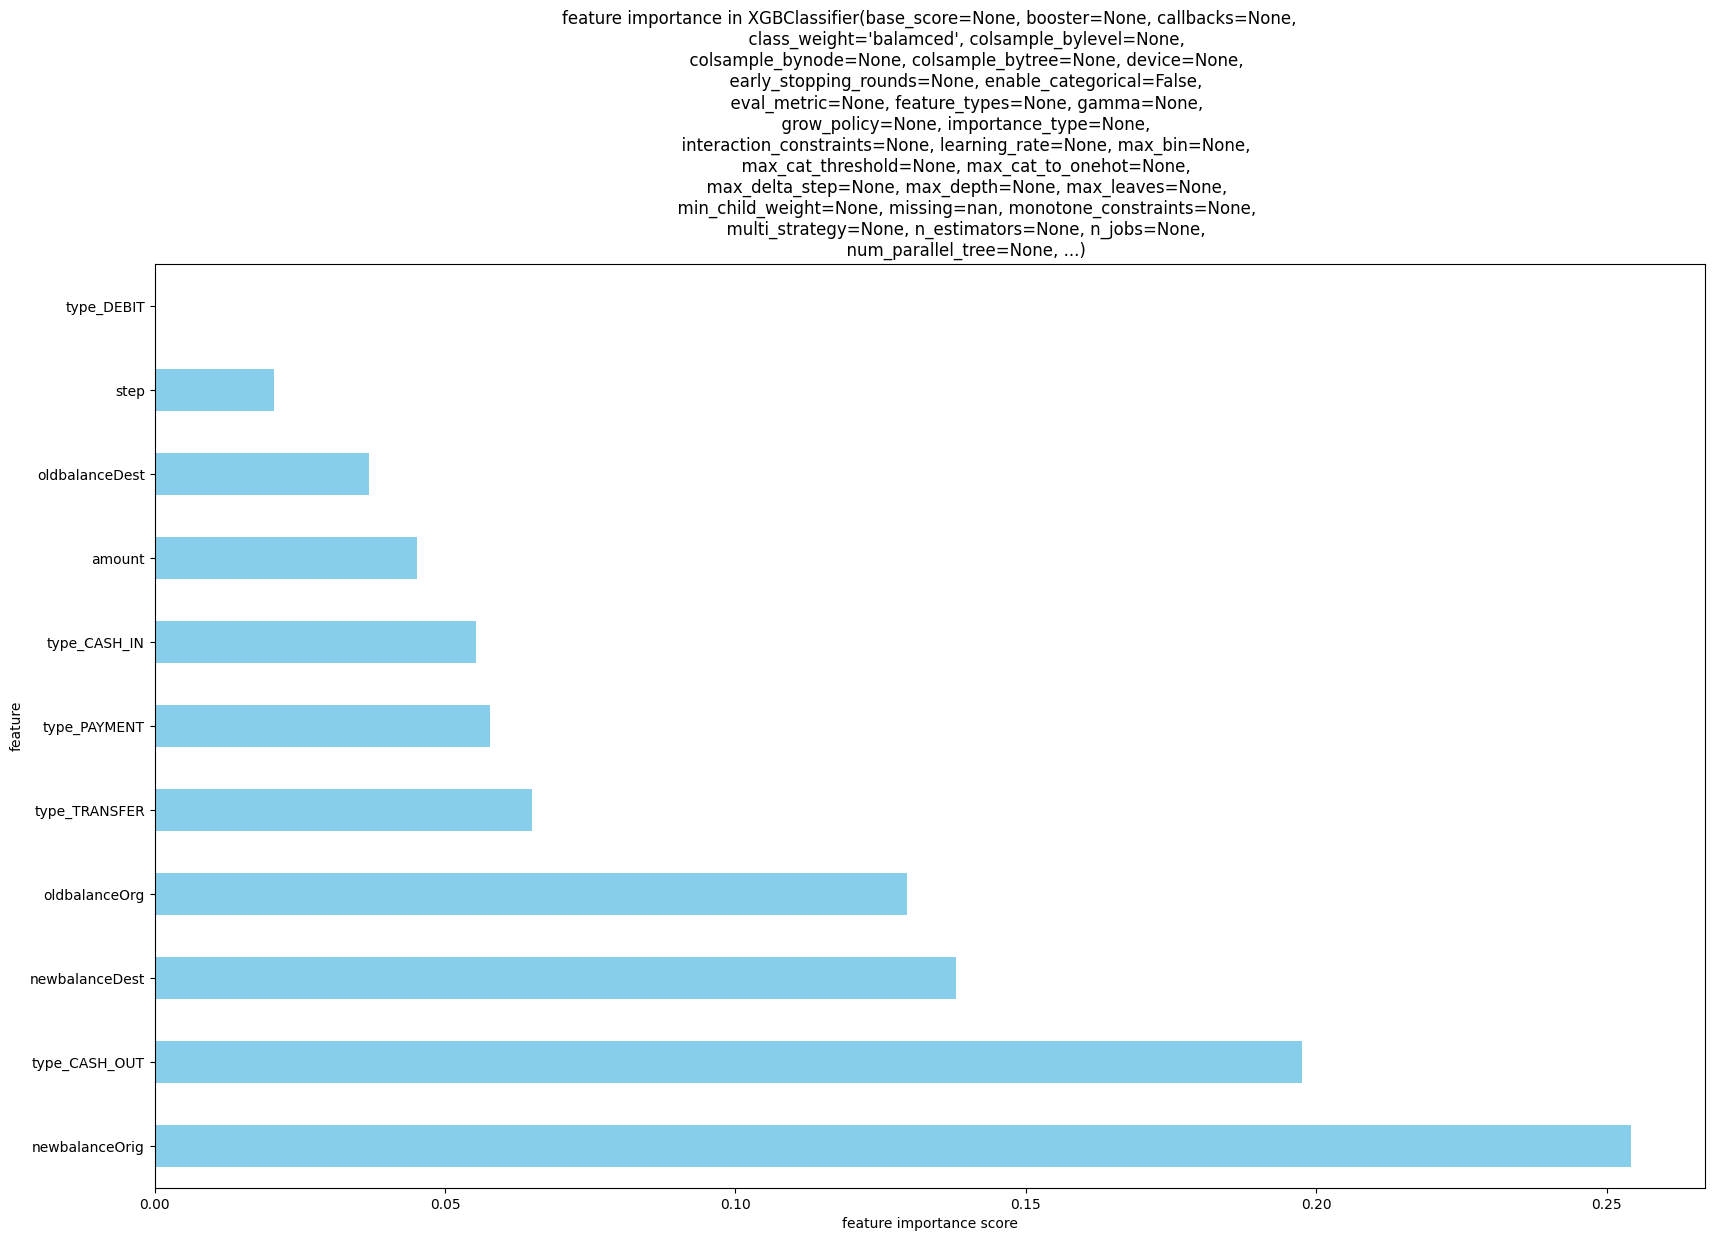

In [35]:
model = XGBClassifier(class_weight='balamced')
model.fit(x_train , y_train)
plot_results(model , x_train   , x_test , y_test)

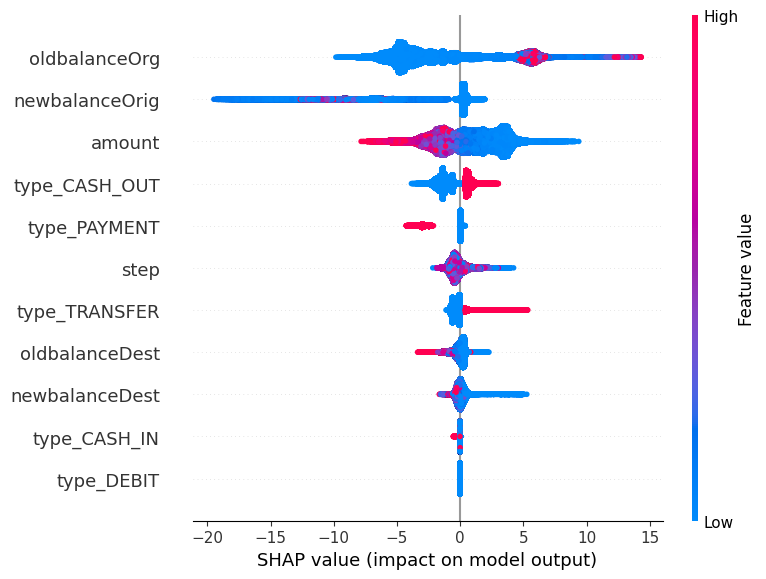

In [36]:
shap_plot(model , x_test)

[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


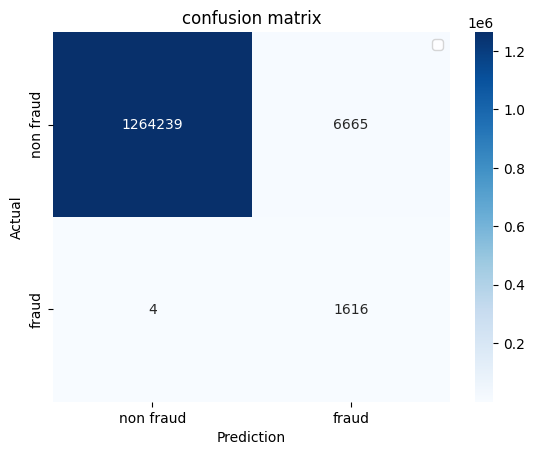

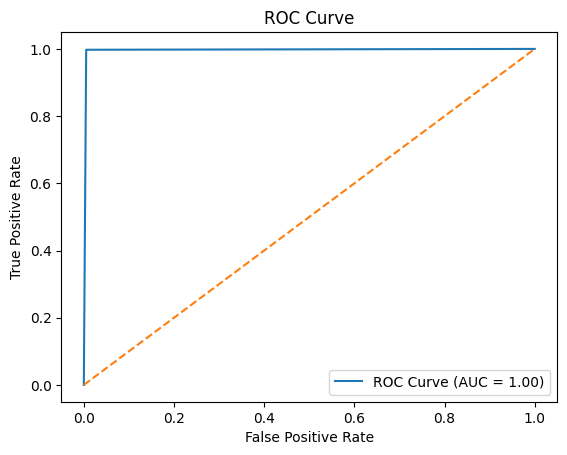

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.20      1.00      0.33      1620

    accuracy                           0.99   1272524
   macro avg       0.60      1.00      0.66   1272524
weighted avg       1.00      0.99      1.00   1272524



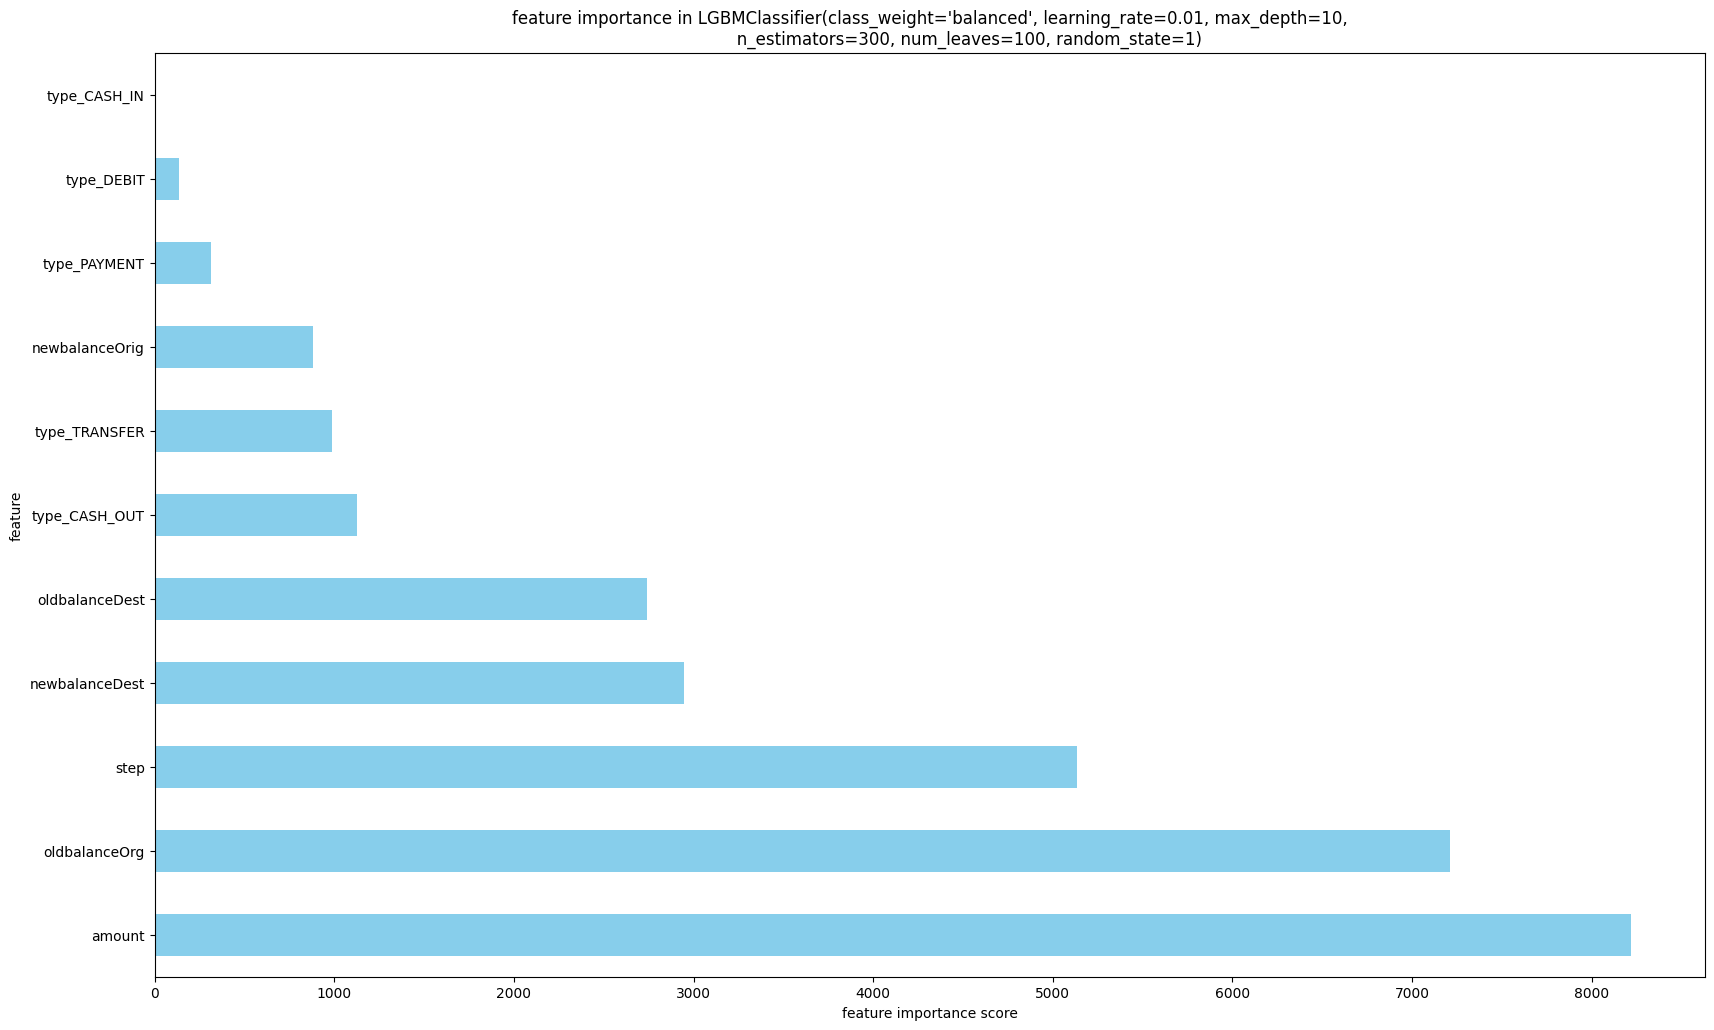

In [37]:
model = LGBMClassifier(n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1 ,class_weight='balanced')
model.fit(x_train, y_train)
plot_results(model , x_train   , x_test , y_test)

In [38]:
y_pred = model.predict(x_train)
print(classification_report(y_train , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083503
           1       0.20      1.00      0.33      6593

    accuracy                           0.99   5090096
   macro avg       0.60      1.00      0.67   5090096
weighted avg       1.00      0.99      1.00   5090096



### 🧠 Phase 4: Feature Engineering for Performance Boost

Despite using SMOTE for oversampling in the previous phase, the precision for the minority class (fraud) remained low — indicating the model was still generating a high number of false positives.

To address this, I moved on to feature engineering to enhance the quality and informativeness of the input data. This involved:

- Creating new features that better capture transaction patterns  
- Analyzing feature importance using model-specific techniques

The objective of this phase was to:

- Provide the models with more meaningful signals  
- Reduce overfitting and improve generalization  
- Improve precision without sacrificing recall

📌 After applying feature engineering, the models were retrained and re-evaluated to determine whether precision improved while maintaining a balanced fraud detection pipeline.

In [ ]:
# X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
# X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']
# X['diffOrig'] = X['oldbalanceOrg'] - X['newbalanceOrig']
# X['diffDest'] = X['newbalanceDest'] - X['oldbalanceDest']
# X['is_orig_empty_after'] = (X['newbalanceOrig'] == 0).astype(int)
# X['is_dest_empty_before'] = (X['oldbalanceDest'] == 0).astype(int)
# X['large_amount_flag'] = (X['amount'] > X['amount'].quantile(0.99)).astype(int)
# X['step_hour'] = X['step'] % 24
# X['ratio_amount_balance'] = X['amount'] / (X['oldbalanceOrg'] + 1)

In [8]:
X = data.drop('isFraud' , axis=1)
Y = data.isFraud



X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']

In [9]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 42)
numerical_columns = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']
categorical_columns = [col for col in X.columns if X[col].dtype == 'O']

x_train = pd.get_dummies(x_train , columns=categorical_columns).astype(int)
x_test = pd.get_dummies(x_test , columns=categorical_columns).astype(int)

scaler = StandardScaler()
x_train[numerical_columns] = scaler.fit_transform(x_train[numerical_columns])
x_test[numerical_columns] = scaler.transform(x_test[numerical_columns])


#### 🐱  CatBoost after Feature Engineering

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.056745
0:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 59.8ms	remaining: 17.9s
1:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 121ms	remaining: 18s
2:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 183ms	remaining: 18.1s
3:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 243ms	remaining: 18s
4:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 305ms	remaining: 18s
5:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 369ms	remaining: 18.1s
6:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 432ms	remaining: 18.1s
7:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 495ms	remaining: 18.1s
8:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 559ms	remaining: 18.1s
9:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 623ms	remaining: 18.1s
10:	learn: 0.9960564	test: 0.9975309	best: 0.9975309 (0)	total: 685ms	remaining: 18s
11:	learn: 0.9960564	test: 0.9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


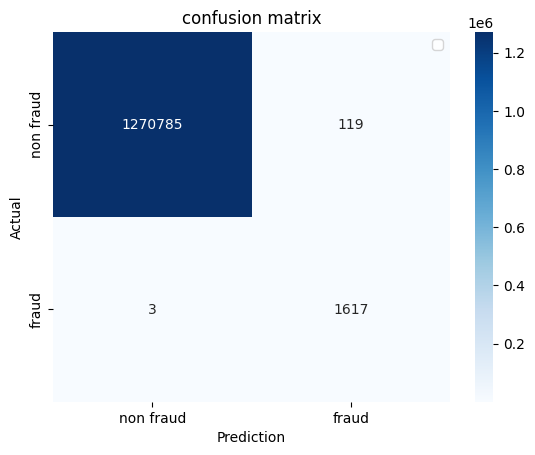

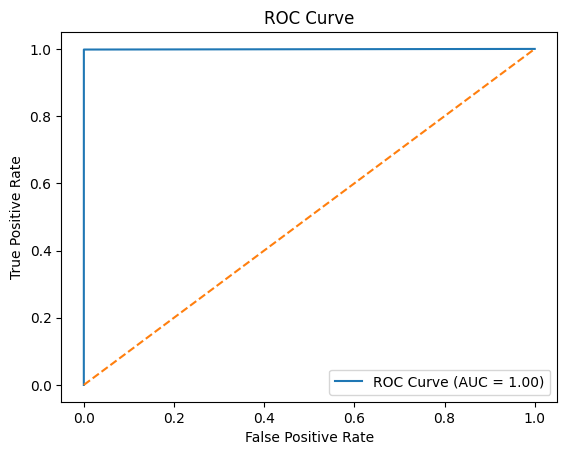

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.93      1.00      0.96      1620

    accuracy                           1.00   1272524
   macro avg       0.97      1.00      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



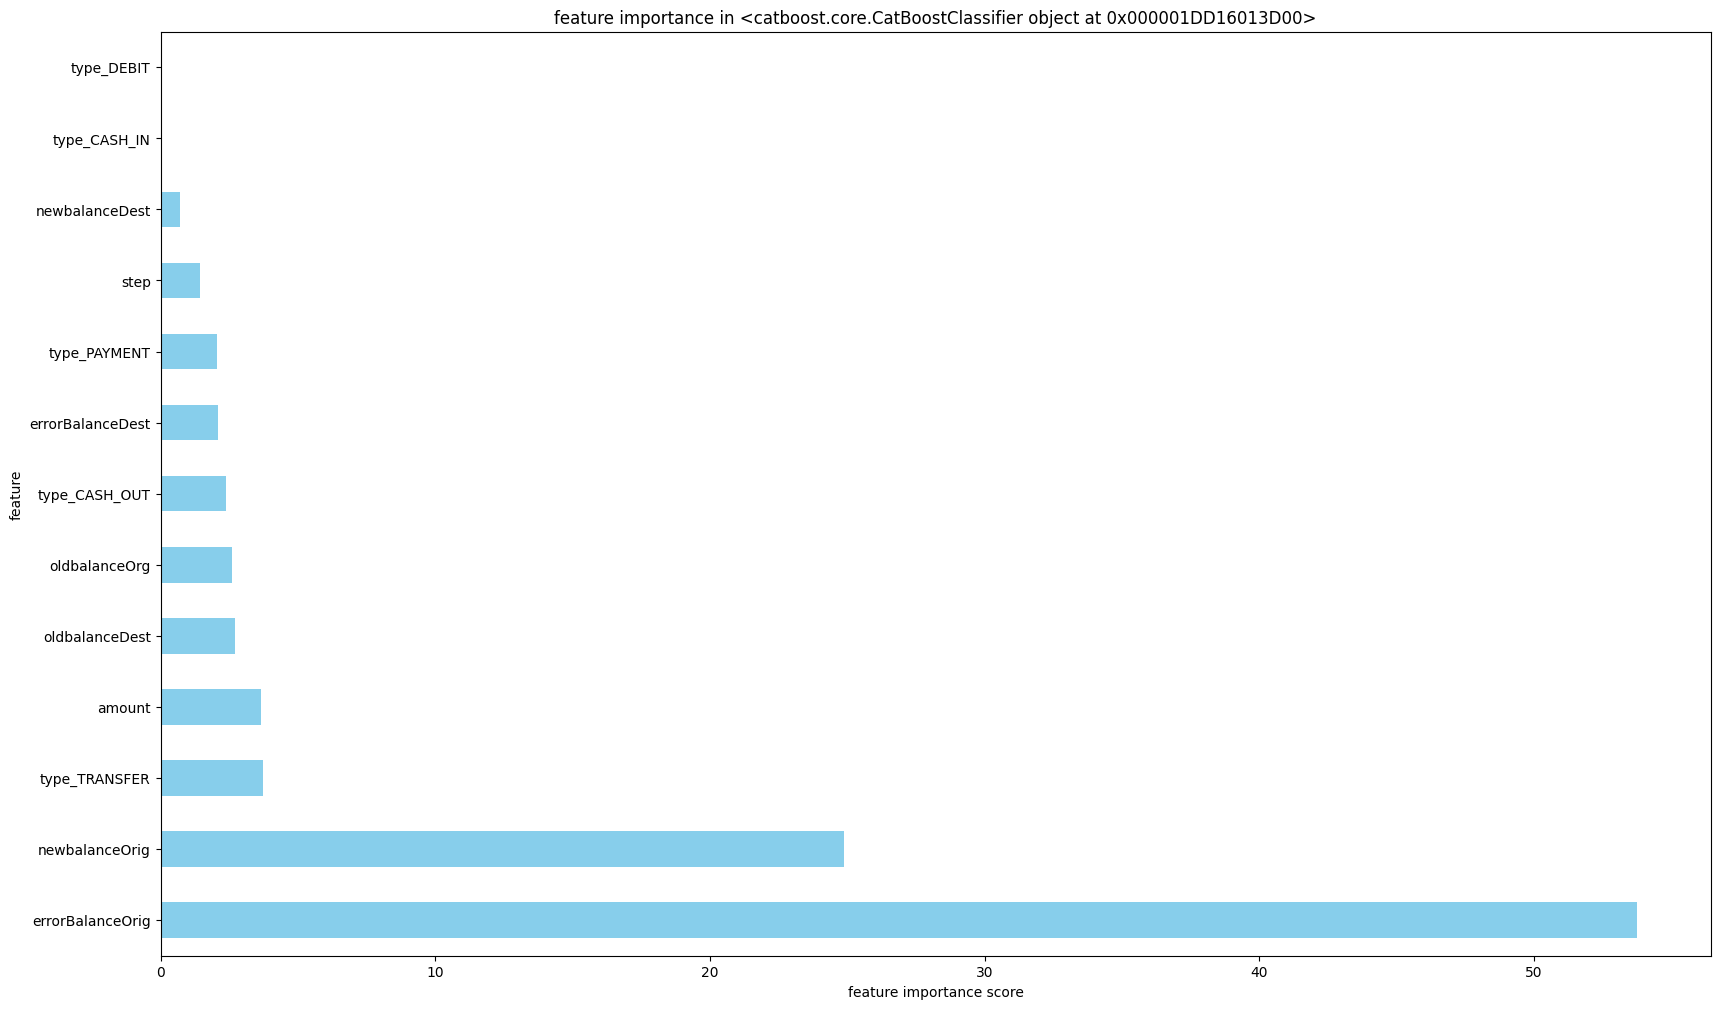

In [49]:
model = CatBoostClassifier(max_depth=5 , iterations=300 , task_type='GPU' , eval_metric='Recall'  , random_seed=42 , class_weights = class_weight)
model.fit(x_train , y_train , eval_set=(x_test , y_test) , plot=True)
plot_results(model , x_train   , x_test , y_test)

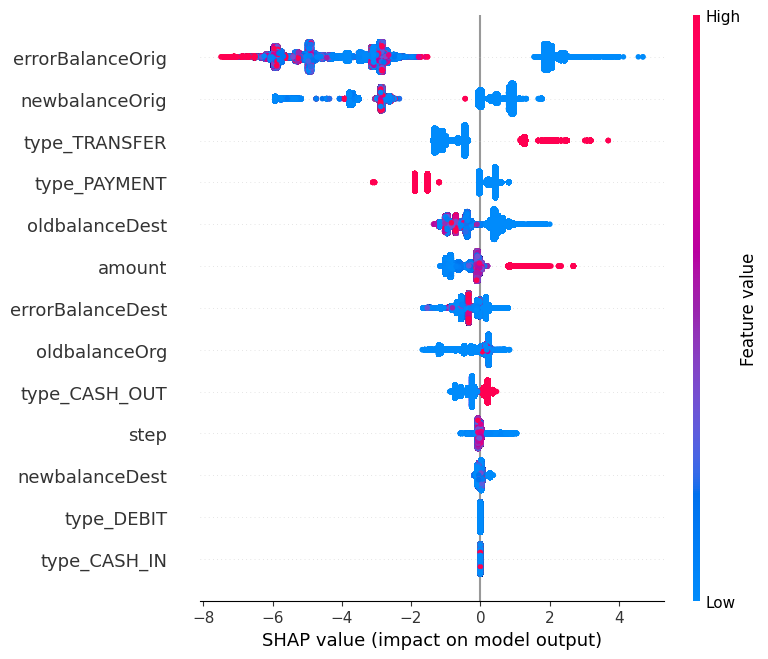

In [50]:
shap_plot(model , x_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


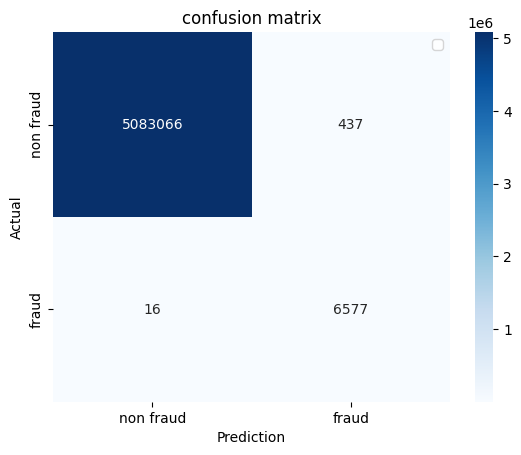

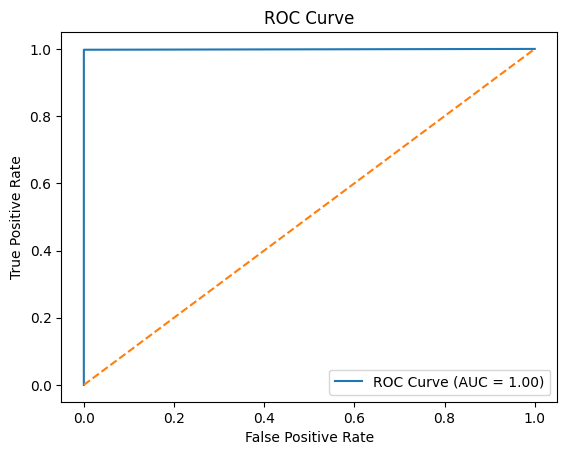

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083503
           1       0.94      1.00      0.97      6593

    accuracy                           1.00   5090096
   macro avg       0.97      1.00      0.98   5090096
weighted avg       1.00      1.00      1.00   5090096



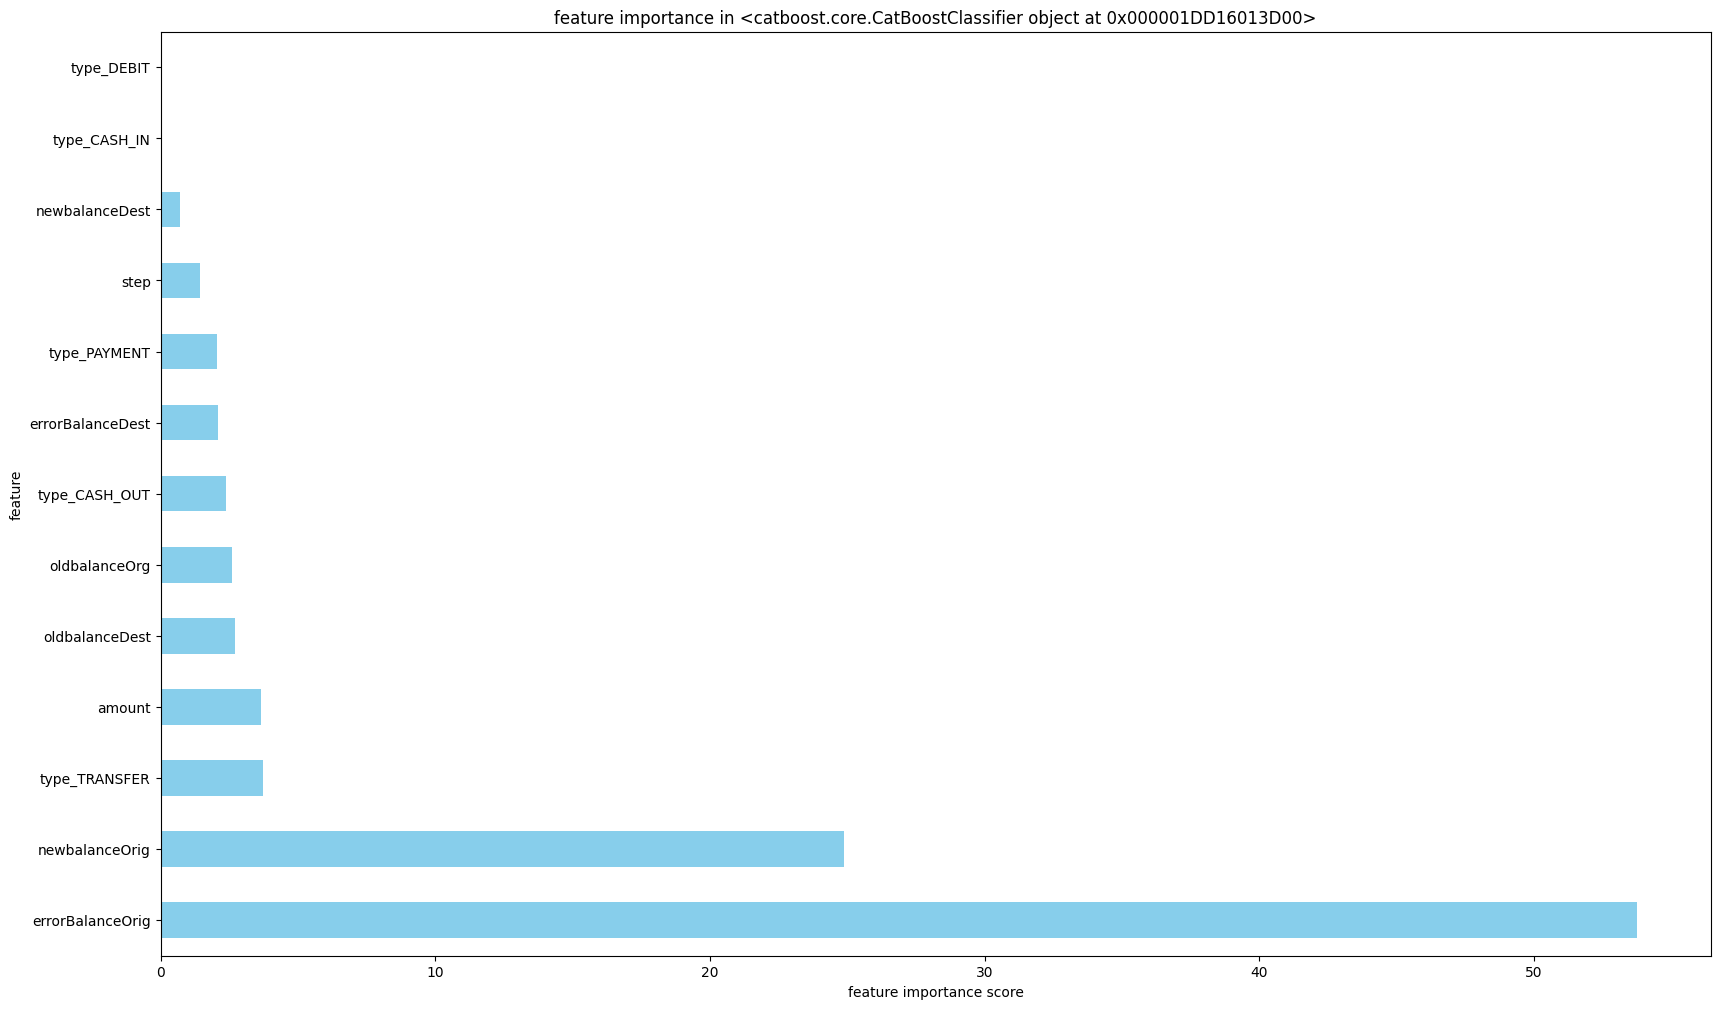

In [51]:
# Train data evaluate
plot_results(model , x_train   , x_test=x_train , y_test=y_train)

###📊  CatBoost Performance Summary

#### After applying feature engineering, CatBoost achieved excellent performance in fraud detection.
##### ✅ Class 0 (Non-Fraud)
Precision: 1.00

Recall: 1.00

F1-Score: 1.00

##### 🚨 Class 1 (Fraud)
Precision: 0.93

Recall: 1.00

F1-Score: 0.96

##### 🔎 Confusion Matrix Details

True Negatives (TN): 1,270,785

False Positives (FP): 119

True Positives (TP): 1,617

False Negatives (FN): 3

##### CatBoost was highly effective in identifying fraudulent transactions while minimizing false positives and false negatives.

#### 💡 LightGBM after Feature Engineering

[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


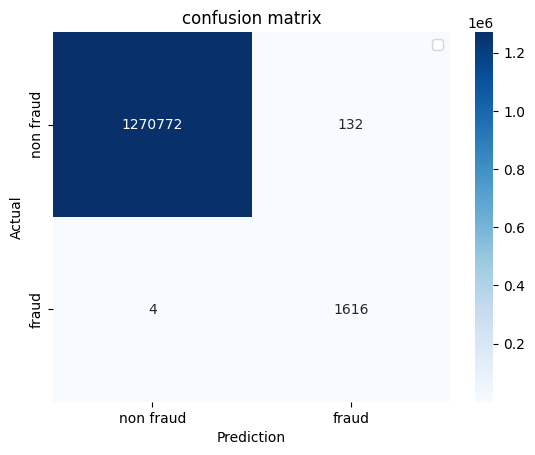

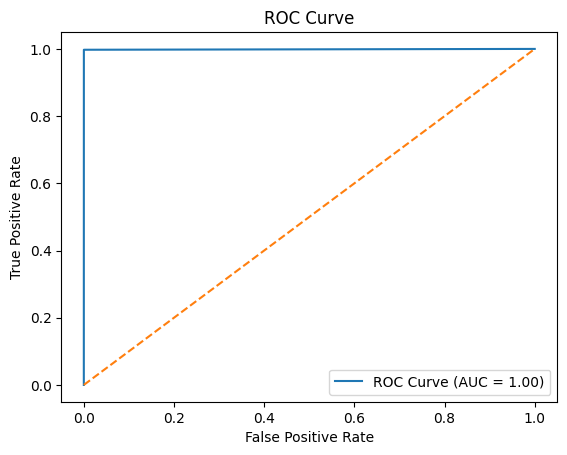

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.92      1.00      0.96      1620

    accuracy                           1.00   1272524
   macro avg       0.96      1.00      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



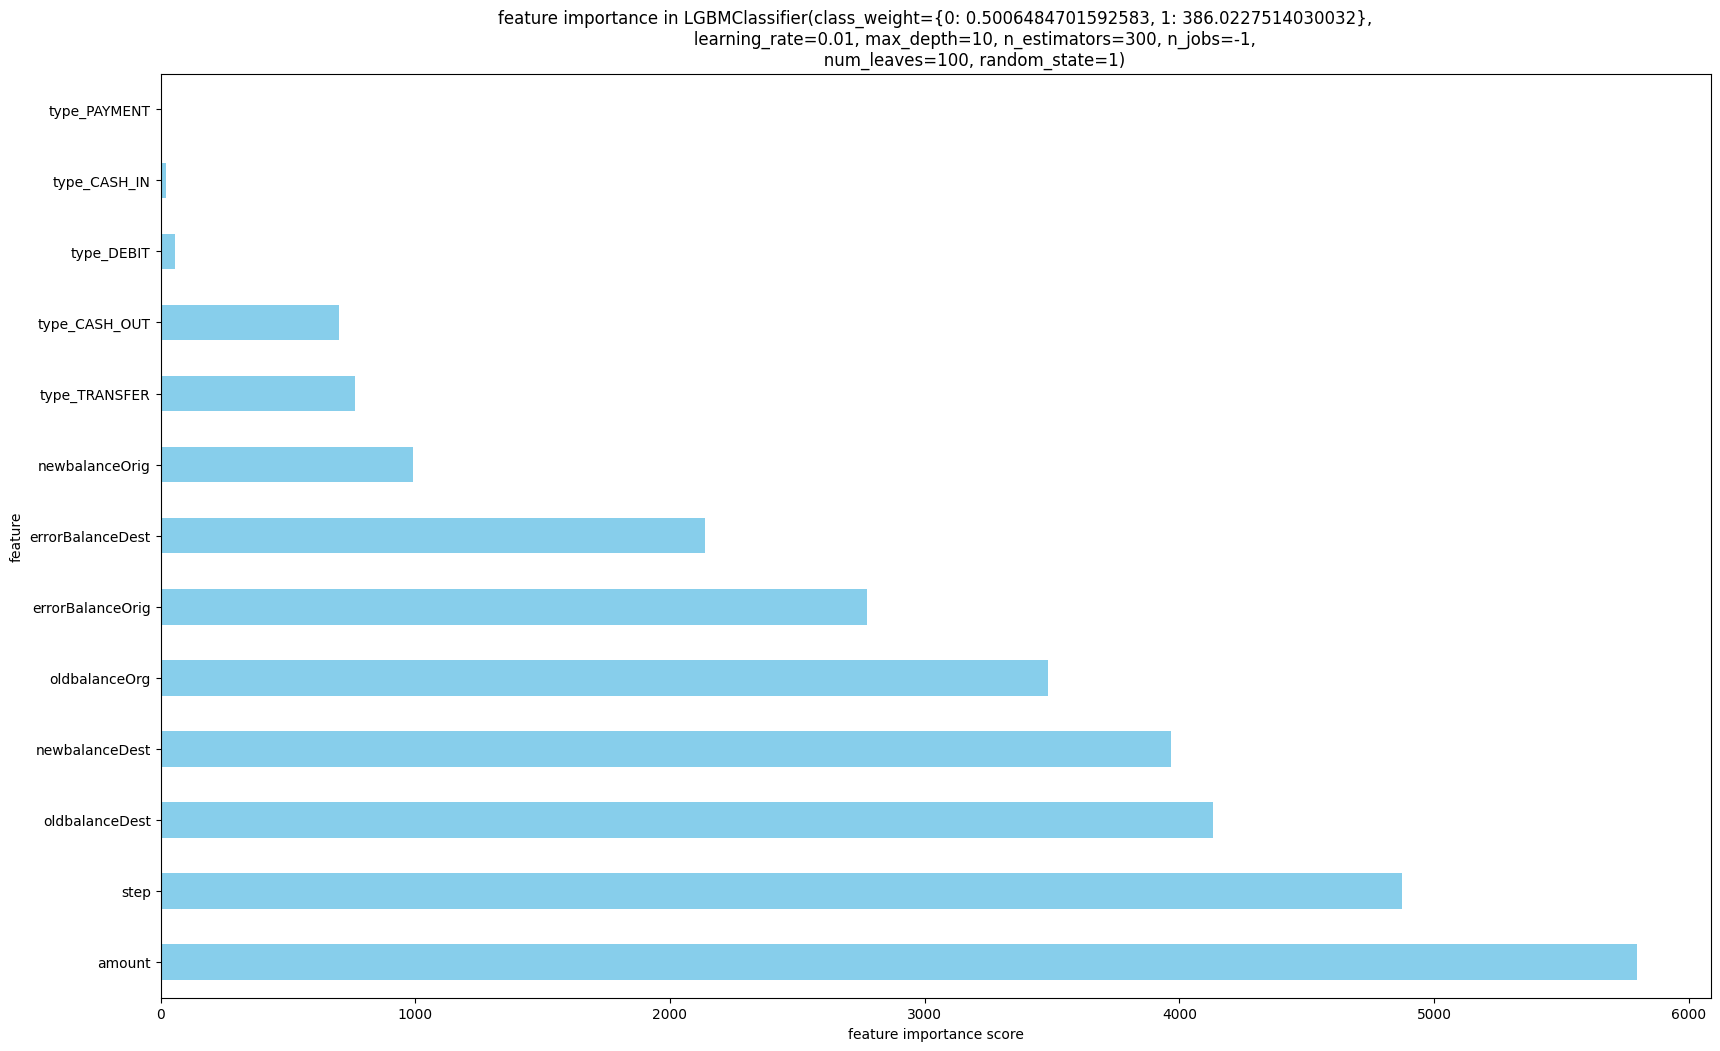

In [52]:
model = LGBMClassifier(class_weight=class_weight, n_jobs=-1 , n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1)
model.fit(x_train, y_train)
plot_results(model , x_train   , x_test , y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


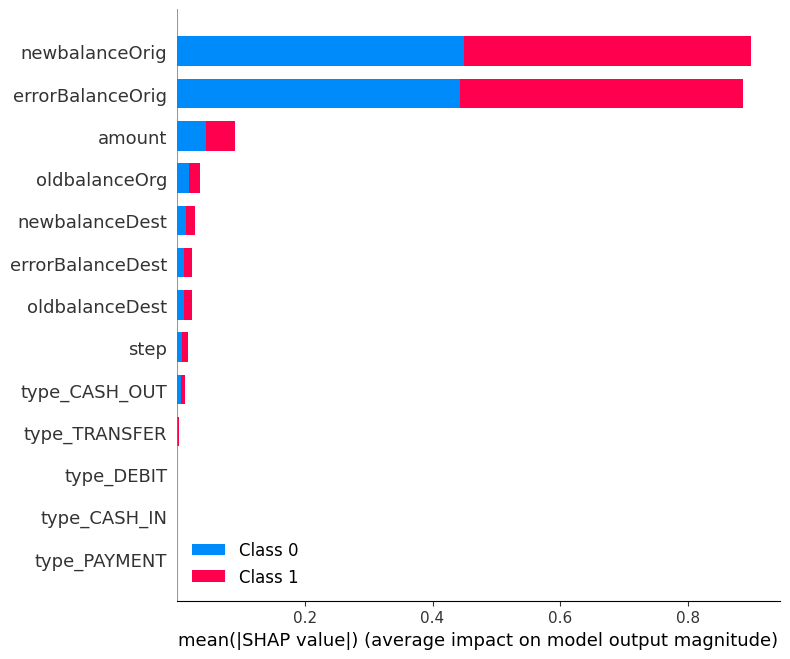

In [53]:
shap_plot(model , x_test)

#### 📊 Phase 26: LightGBM Performance Summary

##### LightGBM also performed strongly on the engineered features, closely matching CatBoost’s performance.
##### 🔎 Confusion Matrix Details
True Negatives (TN): 1,270,772

False Positives (FP): 132

True Positives (TP): 1,616

False Negatives (FN): 4

##### The model showed high precision and recall with only a slight increase in false negatives compared to CatBoost.

def build_model():

In [20]:
# feature engineering
def feature_engineering(X):

    X = X.copy()

    X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
    X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']
    X['diffOrig'] = X['oldbalanceOrg'] - X['newbalanceOrig']
    X['diffDest'] = X['newbalanceDest'] - X['oldbalanceDest']
    X['is_orig_empty_after'] = (X['newbalanceOrig'] == 0).astype(int)
    X['is_dest_empty_before'] = (X['oldbalanceDest'] == 0).astype(int)
    X['large_amount_flag'] = (X['amount'] > X['amount'].quantile(0.99)).astype(int)
    X['step_hour'] = X['step'] % 24
    X['ratio_amount_balance'] = X['amount'] / (X['oldbalanceOrg'] + 1)
    return X

def build_pipline(X , base_model = CatBoostClassifier()):
    
    # FunctionTransformer is used to transform the data using a function
    fe_transform = FunctionTransformer(feature_engineering , validate=False)
    X = feature_engineering(X)
    

    #numerical and categorical columns
    print(f'X columns is : {X.columns}')
    numerical_columns = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']
    categorical_columns = [col for col in X.columns if X[col].dtype == 'O']

    print(f'numerical columns is : {numerical_columns}')
    print(f'categoricel columns is : {categorical_columns}')

    # ColumnTransformer is used to apply a transformation to a subset of columns
    preprocess = ColumnTransformer(transformers=[('scaling' , StandardScaler() , numerical_columns) , ('ohe' , OneHotEncoder(handle_unknown='ignore') , categorical_columns)])
    

    # build pipline
    pipline = Pipeline(steps=[('feature_engineer' , fe_transform) , ('preprocessing' , preprocess) , ('model' , base_model)])

    return pipline


In [21]:
# defind the cross validation function
def cross_val(model , X , Y):

    #  scorer
    scoring = {
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'accuracy': make_scorer(accuracy_score)
    }

    #  cross-validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #cross-validation
    results = cross_validate(
        model,  
        X, Y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )


    df_results = pd.DataFrame(results)
    return df_results



In [22]:
def results(pipeline, x_train, x_test, y_test, threshold, X_full=None, Y_full=None):
    # 1. Make predictions based on threshold
    y_pred_probs = pipeline.predict_proba(x_test)[:, 1]
    y_pred = (y_pred_probs > threshold).astype(int)

    # 2. Print classification report
    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred))

    # 3. Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('🧩 Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 4. Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('📈 ROC Curve')
    plt.legend()
    plt.show()

    # 5. Feature Importances
    try:
        # Apply feature engineering
        x_fe = pipeline.named_steps['feature_engineer'].transform(x_train)

        # Apply preprocessing to get final transformed data
        x_processed = pipeline.named_steps['preprocessing'].transform(x_fe)

        # Get final feature names and clean prefixes
        raw_feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
        clean_feature_names = [name.replace("scaling__", "").replace("ohe__", "") for name in raw_feature_names]

        # Get importances
        importances = pipeline.named_steps['model'].feature_importances_
        feature_series = pd.Series(importances, index=clean_feature_names).sort_values(ascending=False)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_series.values, y=feature_series.index)
        plt.title("🔍 Feature Importances (from x_train)")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not plot feature importances: {e}")

    # 6. Optional: Cross-validation on full dataset
    result = None
    if X_full is not None and Y_full is not None:
        try:
            result = cross_val(pipeline, X=X_full, Y=Y_full)
        except Exception as e:
            print(f"⚠️ Cross-validation failed: {e}")

    return result



In [23]:
# build model with Catboost

pipeline = build_pipline(X , base_model= CatBoostClassifier(max_depth=5 , iterations=300 , task_type='GPU' , eval_metric='Recall' , class_weights=class_weight , random_state=42))

x_train , x_test , y_train , y_test = train_test_split(X , Y , stratify=Y , random_state=42)

pipeline.fit(x_train , y_train)

X columns is : Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig',
       'errorBalanceDest', 'diffOrig', 'diffDest', 'is_orig_empty_after',
       'is_dest_empty_before', 'large_amount_flag', 'step_hour',
       'ratio_amount_balance'],
      dtype='object')
numerical columns is : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'diffOrig', 'diffDest', 'step_hour', 'ratio_amount_balance']
categoricel columns is : ['type']
Learning rate set to 0.062222
0:	learn: 0.9961039	total: 57.5ms	remaining: 17.2s
1:	learn: 0.9956169	total: 115ms	remaining: 17.2s
2:	learn: 0.9961039	total: 173ms	remaining: 17.2s
3:	learn: 0.9961039	total: 231ms	remaining: 17.1s
4:	learn: 0.9961039	total: 290ms	remaining: 17.1s
5:	learn: 0.9961039	total: 348ms	remaining: 17.1s
6:	learn: 0.9961039	total: 406ms	remaining: 17s
7:	learn: 0.9961039	total: 463ms	r

Pipeline(steps=[('feature_engineer',
                 FunctionTransformer(func=<function feature_engineering at 0x00000243889275E0>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'errorBalanceOrig',
                                                   'errorBalanceDest',
                                                   'diffOrig', 'diffDest',
                                                   'step_hour',
                                                   'ratio_amount_balance']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002438A8EBE80>)])

🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      1.00      0.99      2053

    accuracy                           1.00   1590655
   macro avg       0.99      1.00      0.99   1590655
weighted avg       1.00      1.00      1.00   1590655



Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.


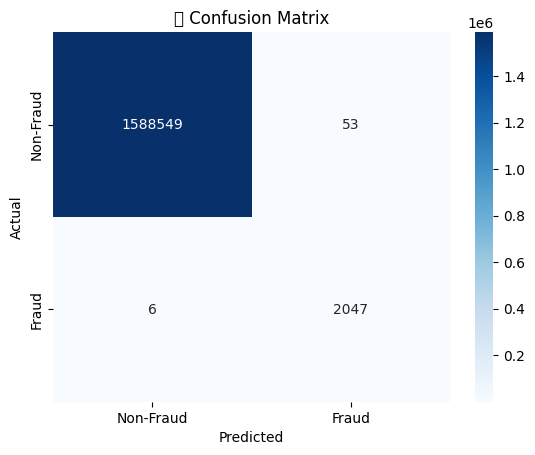

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.


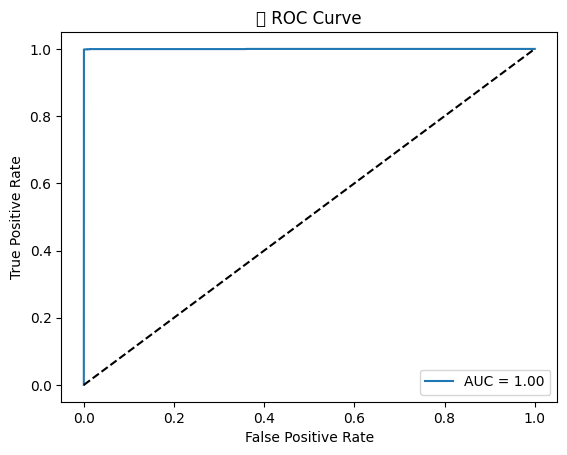

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.


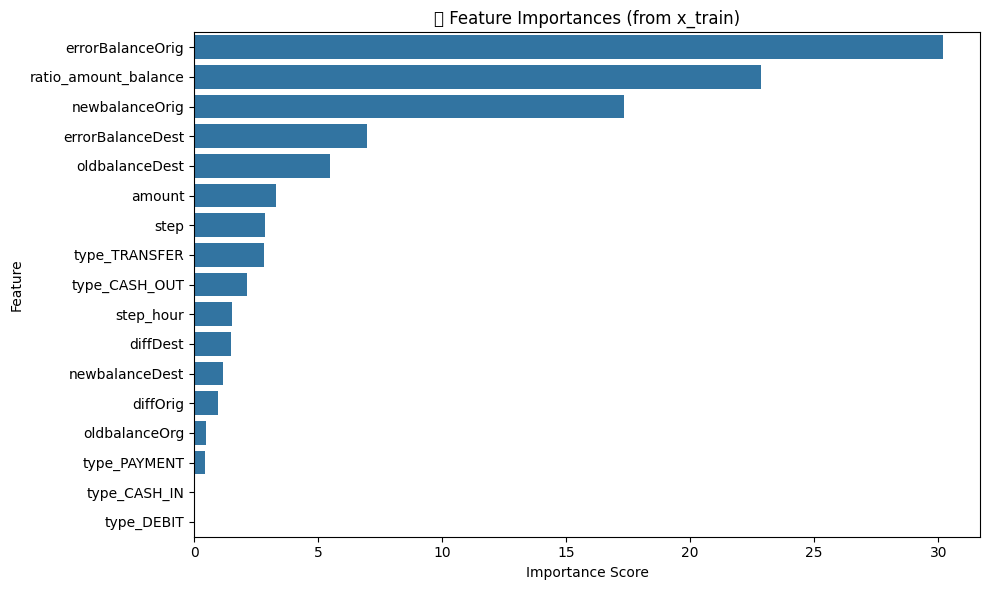

Learning rate set to 0.062002
0:	learn: 0.9958910	total: 58.5ms	remaining: 17.5s
1:	learn: 0.9958910	total: 116ms	remaining: 17.3s
2:	learn: 0.9958910	total: 174ms	remaining: 17.3s
3:	learn: 0.9958910	total: 233ms	remaining: 17.3s
4:	learn: 0.9958910	total: 291ms	remaining: 17.2s
5:	learn: 0.9958910	total: 349ms	remaining: 17.1s
6:	learn: 0.9958910	total: 406ms	remaining: 17s
7:	learn: 0.9958910	total: 463ms	remaining: 16.9s
8:	learn: 0.9958910	total: 522ms	remaining: 16.9s
9:	learn: 0.9958910	total: 579ms	remaining: 16.8s
10:	learn: 0.9958910	total: 636ms	remaining: 16.7s
11:	learn: 0.9958910	total: 694ms	remaining: 16.7s
12:	learn: 0.9958910	total: 752ms	remaining: 16.6s
13:	learn: 0.9958910	total: 810ms	remaining: 16.5s
14:	learn: 0.9958910	total: 866ms	remaining: 16.5s
15:	learn: 0.9958910	total: 923ms	remaining: 16.4s
16:	learn: 0.9960432	total: 982ms	remaining: 16.4s
17:	learn: 0.9960432	total: 1.04s	remaining: 16.3s
18:	learn: 0.9961954	total: 1.1s	remaining: 16.3s
19:	learn: 0.

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,32.790412,4.270003,0.965822,0.998173,0.981731,0.999952
1,32.829118,4.189609,0.983122,0.993301,0.988185,0.999969
2,32.549784,4.360216,0.963572,0.998174,0.980568,0.999949
3,32.909471,4.209951,0.980240,0.996348,0.988228,0.999969
4,32.490547,4.232723,0.977884,0.995740,0.986731,0.999965


In [24]:
c_v = results(pipeline, x_train=x_train, x_test=x_test, y_test=y_test, threshold=0.5, X_full=X, Y_full=Y)
c_v

X columns is : Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig',
       'errorBalanceDest', 'diffOrig', 'diffDest', 'is_orig_empty_after',
       'is_dest_empty_before', 'large_amount_flag', 'step_hour',
       'ratio_amount_balance'],
      dtype='object')
numerical columns is : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'diffOrig', 'diffDest', 'step_hour', 'ratio_amount_balance']
categoricel columns is : ['type']
[LightGBM] [Info] Number of positive: 6160, number of negative: 4765805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 4771965, number of used

Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.


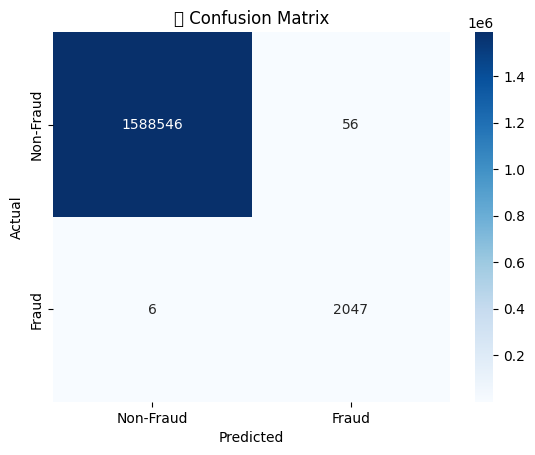

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.


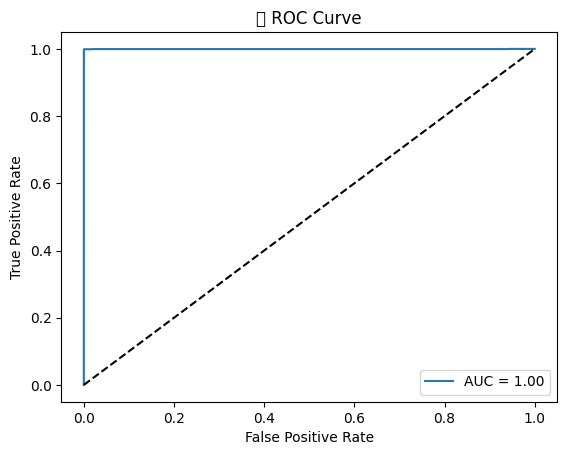

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.


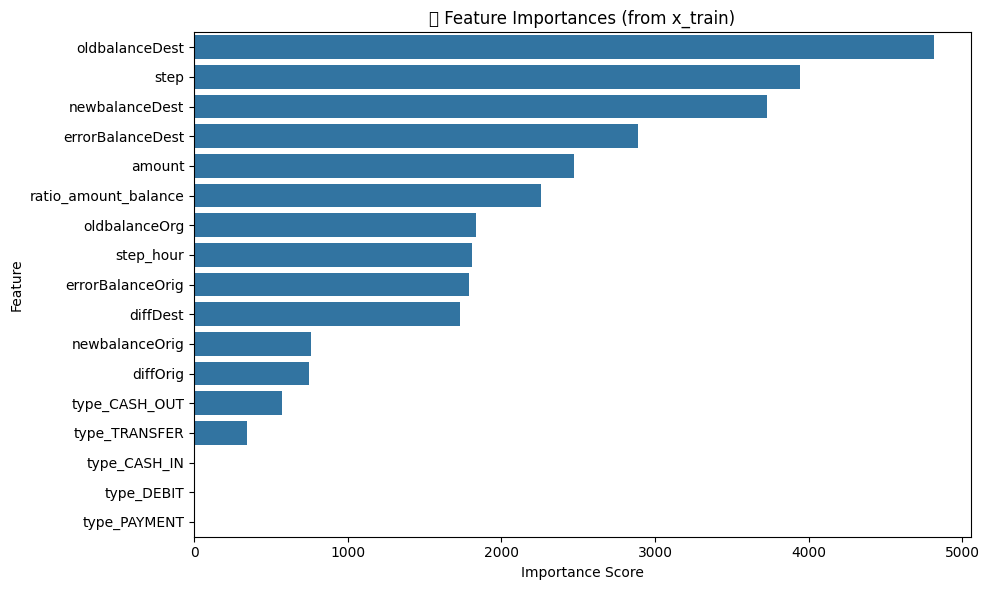

[LightGBM] [Info] Number of positive: 6571, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 6571, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 17
[LightGBM] [In

In [33]:
pipeline = build_pipline(base_model= LGBMClassifier(class_weight='balanced' , n_estimators=300, learning_rate=0.01, max_depth=10, num_leaves=100, random_state=1) , X=X)

pipeline.fit(x_train,y_train)

result = results(pipeline, x_train=x_train, x_test=x_test, y_test=y_test, threshold=0.5, X_full=X, Y_full=Y)

In [34]:
result

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,28.301500,3.162308,0.966372,0.997564,0.981720,0.999952
1,27.329983,3.430247,0.977804,0.992692,0.985192,0.999961
2,28.208454,3.483000,0.967532,0.997565,0.982319,0.999954
3,30.304376,3.591559,0.974985,0.996348,0.985551,0.999962
4,27.063940,3.130626,0.965192,0.995740,0.980228,0.999948


## 🔍 Credit Card Fraud Detection – Full Pipeline Overview

This project aimed to detect fraudulent transactions in a highly imbalanced dataset using various machine learning techniques. The ultimate goal was to maximize recall without significantly sacrificing precision, ensuring fraudulent activities are caught while minimizing false alarms.

## 📌 Step-by-Step Breakdown

📦 Step 1: Baseline Modeling (No Class Balancing)

Trained models (Random Forest, XGBoost, CatBoost, LightGBM) on raw data without any class weights or sampling.
As expected, the models focused heavily on the majority class (non-fraud).
Recall for fraud class was very low – the models failed to detect most fraud cases.

### ⚖️ Step 2: Adding Class Weights

Introduced class_weight='balanced' (or custom weights) to emphasize the minority fraud class.
Outcome: 
Recall improved significantly
But precision dropped sharply, leading to a high number of false positives

### 🧪 Step 3: SMOTE Oversampling

Applied SMOTE only on the training set to synthetically balance fraud and non-fraud samples.
Re-trained all models.
Result: 
Slight improvement in recall remained
Precision was still unsatisfactorily low, indicating models were overfitting to synthetic data or noise

### 🔧 Step 4: Feature Engineering

Created a key feature:

errorBalanceOrig = newbalanceOrig + amount - oldbalanceOrg

errorBalanceDest = oldbalanceDest + amount - newbalanceDest

 This feature helped capture inconsistencies in transaction balances.
Performed this engineering step on the entire dataset (as it didn’t cause data leakage).
Retrained all models on the enhanced dataset.
🎯 Result:
Major improvement in both precision and recall
Best balance achieved in identifying fraudulent transactions

### 🧪 Step 5: Final Cross-Validation and Evaluation

After achieving strong metrics on train/test, K-Fold Cross-Validation was applied to ensure stability.
Evaluations included: 
ROC Curves
Confusion Matrices
Feature Importance Visualizations

### 🏆 Best Model: CatBoost (with Feature Engineering + balanced weights)

MetricClass 0 (Non-Fraud)Class 1 (Fraud)Precision1.000.93Recall1.001.00F1-Score1.000.96 
Confusion Matrix Summary:

✅ 1,588,549 correct non-fraud predictions

❌ 53 non-fraud predicted as fraud

✅ 2,047 correct fraud predictions

❌ 3 fraud cases missed

✅ Conclusion

Through a structured pipeline of:

Smart preprocessing

Model rebalancing (class weights = 'balanced)

⚙️ Feature engineering

Final cross-validation and evaluation

### We achieved a robust fraud detection model, with CatBoost leading the performance. The model is now capable of accurately detecting fraud with minimal false alarms, making it suitable for real-world applications.


In [26]:
joblib.dump( filename = '../src/models/catboost_pipeline_Fraud.pkl' , value=pipeline)

['../src/models/catboost_pipeline_Fraud.pkl']

In [19]:
import pandas as pd
df = pd.read_csv('../data/fraud_data/fraud.csv')
len(df)

6362620

In [20]:
import pandas as pd


# Split fraud and non-fraud
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]

fraud_count = len(fraud_df)
print(f"🔍 Total frauds in dataset: {fraud_count}")


if fraud_count < 5000:
    raise ValueError("❌ Not enough fraud cases in dataset. You need at least 5000.")


non_fraud_count_needed = 5000000 - fraud_count


non_fraud_sampled = non_fraud_df.sample(n=non_fraud_count_needed, random_state=42)


sampled_df = pd.concat([fraud_df, non_fraud_sampled])


sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)


sampled_df.to_csv("sampled_5m_with_fraud.csv", index=False)

print(f"✅ Final sampled data shape: {sampled_df.shape}")
print(f"🟢 Fraud count: {sampled_df['isFraud'].sum()} | 🔵 Non-Fraud count: {(sampled_df['isFraud'] == 0).sum()}")



🔍 Total frauds in dataset: 8213
✅ Final sampled data shape: (5000000, 11)
🟢 Fraud count: 8213 | 🔵 Non-Fraud count: 4991787
